In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.5.2

Using pmdarima 2.0.4


In [3]:
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")
togpunktlighed_daily = data.groupby('dato')['togpunktlighed'].mean().reset_index()

In [4]:
# Split data
train_len = int(togpunktlighed_daily.shape[0] * 0.8)
train_data, test_data = togpunktlighed_daily[:train_len], togpunktlighed_daily[train_len:]

y_train = train_data['togpunktlighed'].values
y_test = test_data['togpunktlighed'].values

print(f"{train_len} train samples")
print(f"{togpunktlighed_daily.shape[0] - train_len} test samples")

2045 train samples
512 test samples


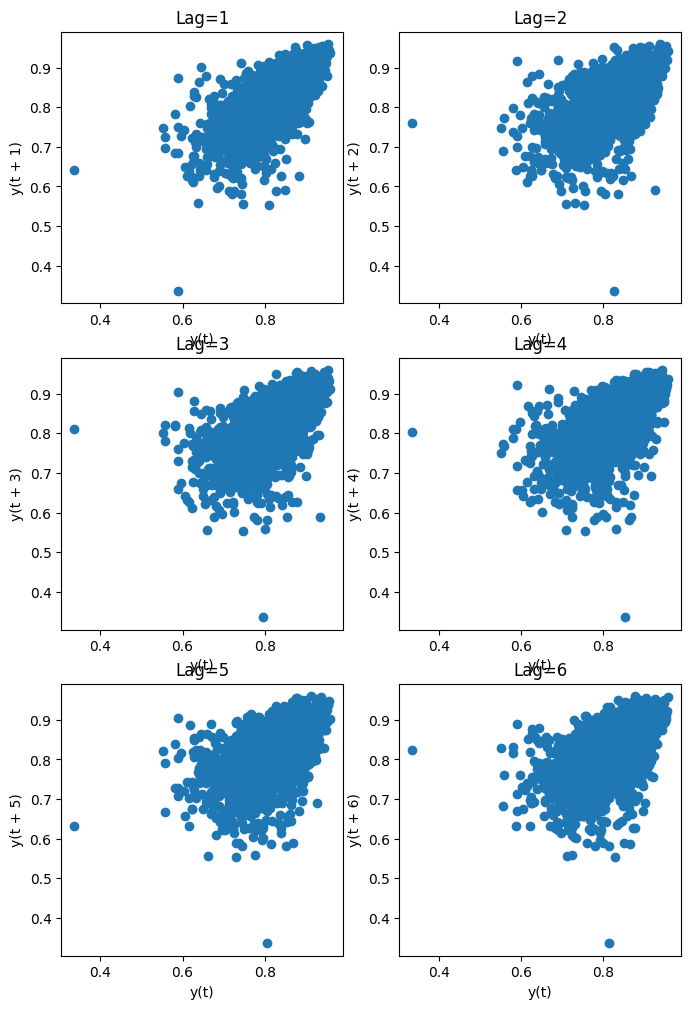

In [5]:
# Pre-modeling analysis - Lag plots
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(togpunktlighed_daily['togpunktlighed'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

In [6]:
# Pre-modeling analysis - Estimanting the differencing term
from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=365)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=365)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [7]:
# Fit a model
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7265.669, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6683.776, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6890.636, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7143.670, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6685.775, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7246.212, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7262.787, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-7253.813, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7263.928, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7264.767, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7253.491, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-7266.449, Time=0.70 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7110.738, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-7267.532, Time=0.89 sec
 ARIMA(4,1,0)(0,0,0

In [8]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 0.0027223348528182473
SMAPE: 5.1887328486376


In [9]:
togpunktlighed_daily['year'] = togpunktlighed_daily['dato'].dt.strftime('%Y')

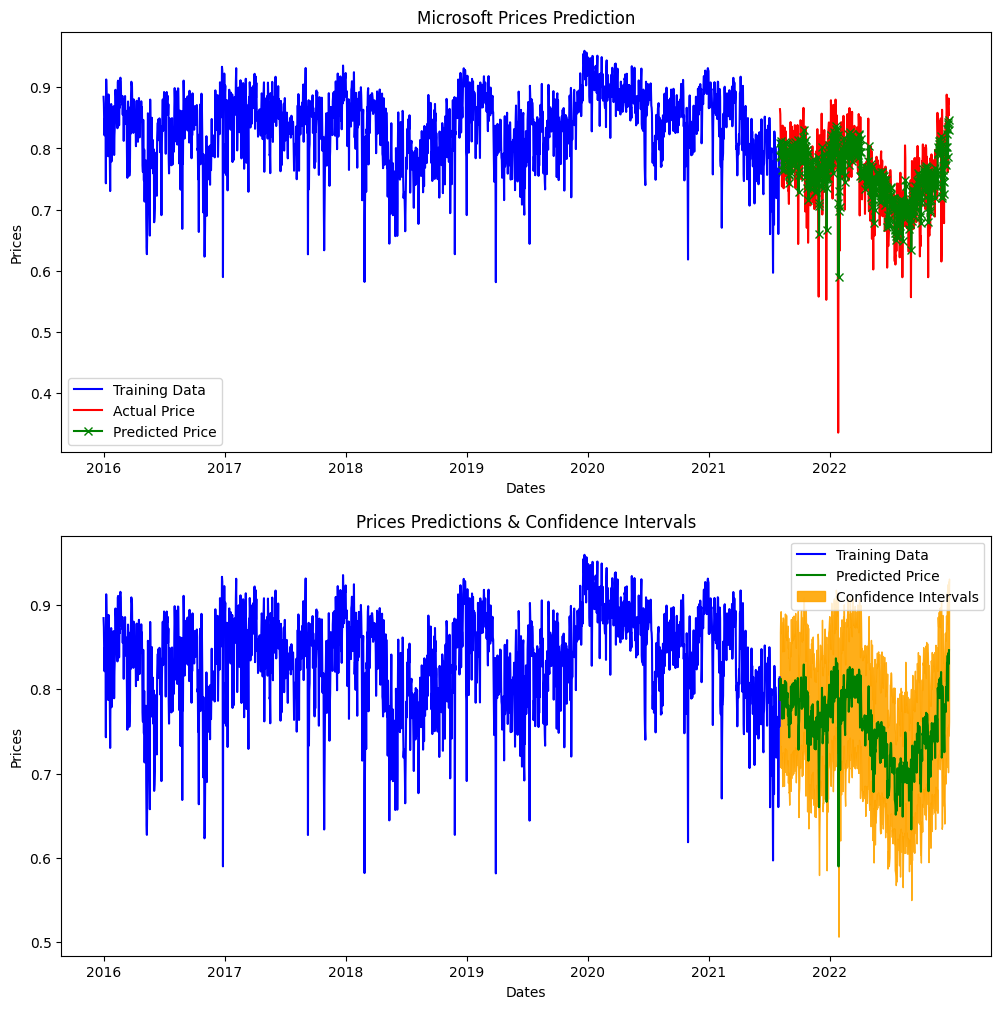

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].plot(test_data.index, forecasts, color='green', marker='x',
             label='Predicted Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 2557, 366).tolist(), togpunktlighed_daily['year'][0:2600:366].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 2557, 366).tolist(), togpunktlighed_daily['year'][0:2600:366].tolist())
axes[1].legend()

In [11]:
# Update with estimate instead of true value
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(fc)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

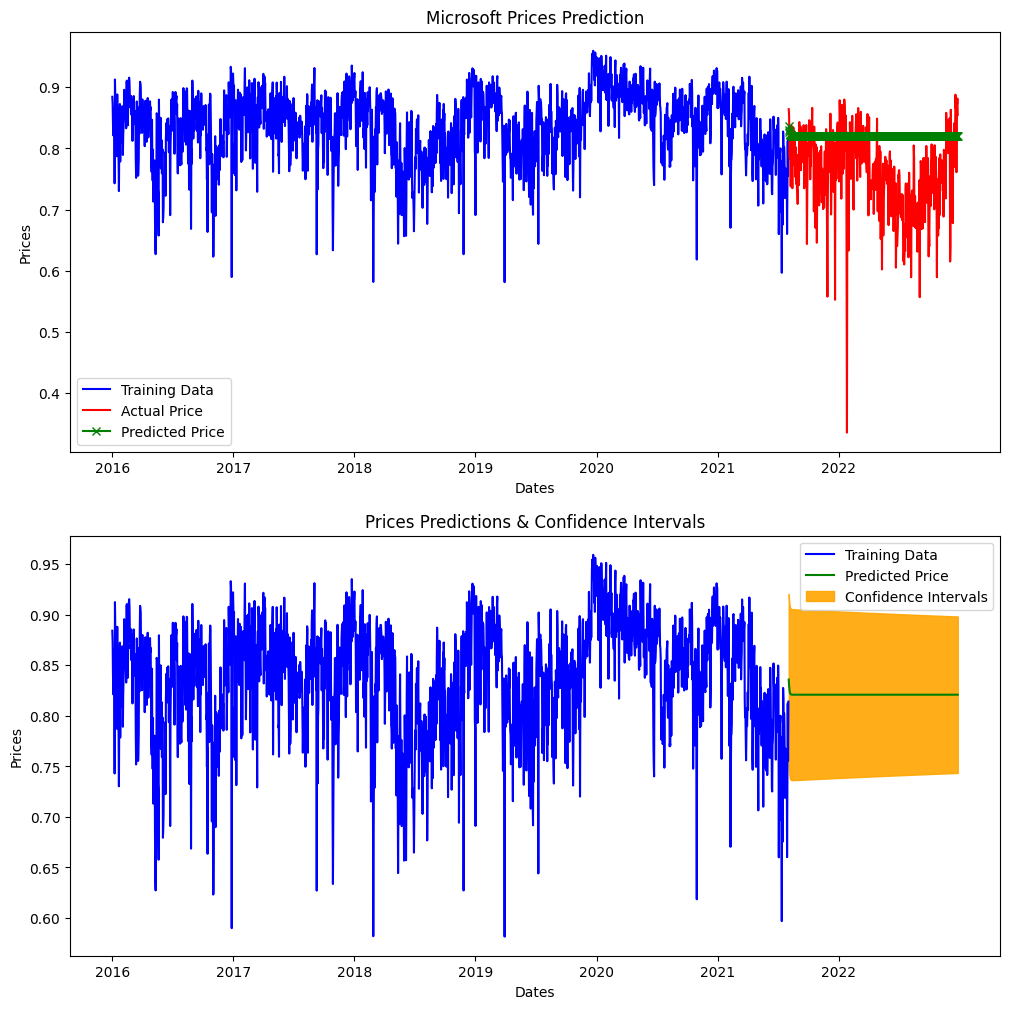

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].plot(test_data.index, forecasts, color='green', marker='x',
             label='Predicted Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 2557, 366).tolist(), togpunktlighed_daily['year'][0:2600:366].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 2557, 366).tolist(), togpunktlighed_daily['year'][0:2600:366].tolist())
axes[1].legend()

# Per strækning

In [110]:
# Load data
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")
togpunktlighed_daily = data.groupby('dato')['togpunktlighed'].mean().reset_index()

In [131]:
# Choose togpunktlighed per strækning and split into test and train set
def togpunktlighed_strækning_split(strækning, ratio=0.1):
    strækning_data = data[data['visualiseringskode'] == strækning]
    togpunktlighed_strækning_daily = strækning_data.groupby('dato')['togpunktlighed'].mean().reset_index()
    train, test = train_test_split(togpunktlighed_strækning_daily, test_size=ratio, shuffle=False)
    return train,test

# Model predictions one step into the future. Returns predictions and confidence interval
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

# Plots the results
togpunktlighed_daily['year'] = togpunktlighed_daily['dato'].dt.strftime('%Y')

def plotting_results(strækning, y_train, y_test, forecasts, confidence_intervals):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --------------------- Actual vs. Predicted --------------------------
    axes[0].plot(y_train, color='blue', label='Training Data')
    axes[0].plot(y_test.index, y_test, color='red', label='Test Data')
    axes[0].plot(y_test.index, forecasts, color='green', marker='x',
             label='Predictions')
    axes[0].set_title(f'Strækning {strækning}: Predictions & True Value')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Togpunktlighed')

    axes[0].set_xticks(np.arange(0, y_train.shape[0]+y_test.shape[0], 366).tolist(), togpunktlighed_daily['year'][0:y_train.shape[0]+y_test.shape[0]:366].tolist())
    axes[0].legend(loc='lower left')


# ------------------ Predicted with confidence intervals ----------------
    axes[1].plot(y_train, color='blue', label='Training Data')
    axes[1].plot(y_test.index, forecasts, color='green',
             label='Predicted Values')

    axes[1].set_title(f'Strækning {strækning}: Predictions & Confidence Intervals')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Togpunktlighed')
    conf_int = np.asarray(confidence_intervals)
    axes[1].fill_between(y_test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

    axes[1].set_xticks(np.arange(0, 2557, 366).tolist(), togpunktlighed_daily['year'][0:2600:366].tolist())
    axes[1].legend(loc='lower left')

In [119]:
data_each_strækning = {}
for strækning in np.sort(data['visualiseringskode'].unique()):
    train, test = togpunktlighed_strækning_split(strækning, ratio=0.1)
    y_train, y_test = train['togpunktlighed'], test['togpunktlighed']

    model = pm.auto_arima(y_train, d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)
    forecasts = []
    confidence_intervals = []

    for new_ob in y_test:
        fc, conf = forecast_one_step()
        forecasts.append(fc)
        confidence_intervals.append(conf)
        
        # Updates the existing model with a small number of MLE steps
        model.update(new_ob)
    results = [y_train, y_test, forecasts, confidence_intervals, model, mean_squared_error(y_test, forecasts)]
    data_each_strækning[strækning] = results
    print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4955.520, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4472.498, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4677.045, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4868.123, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4474.498, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4956.147, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4954.233, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4957.249, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4955.917, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4818.450, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4959.243, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4870.119, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4679.045, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4957.911, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0

/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1318/2587770143.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(20, 8))


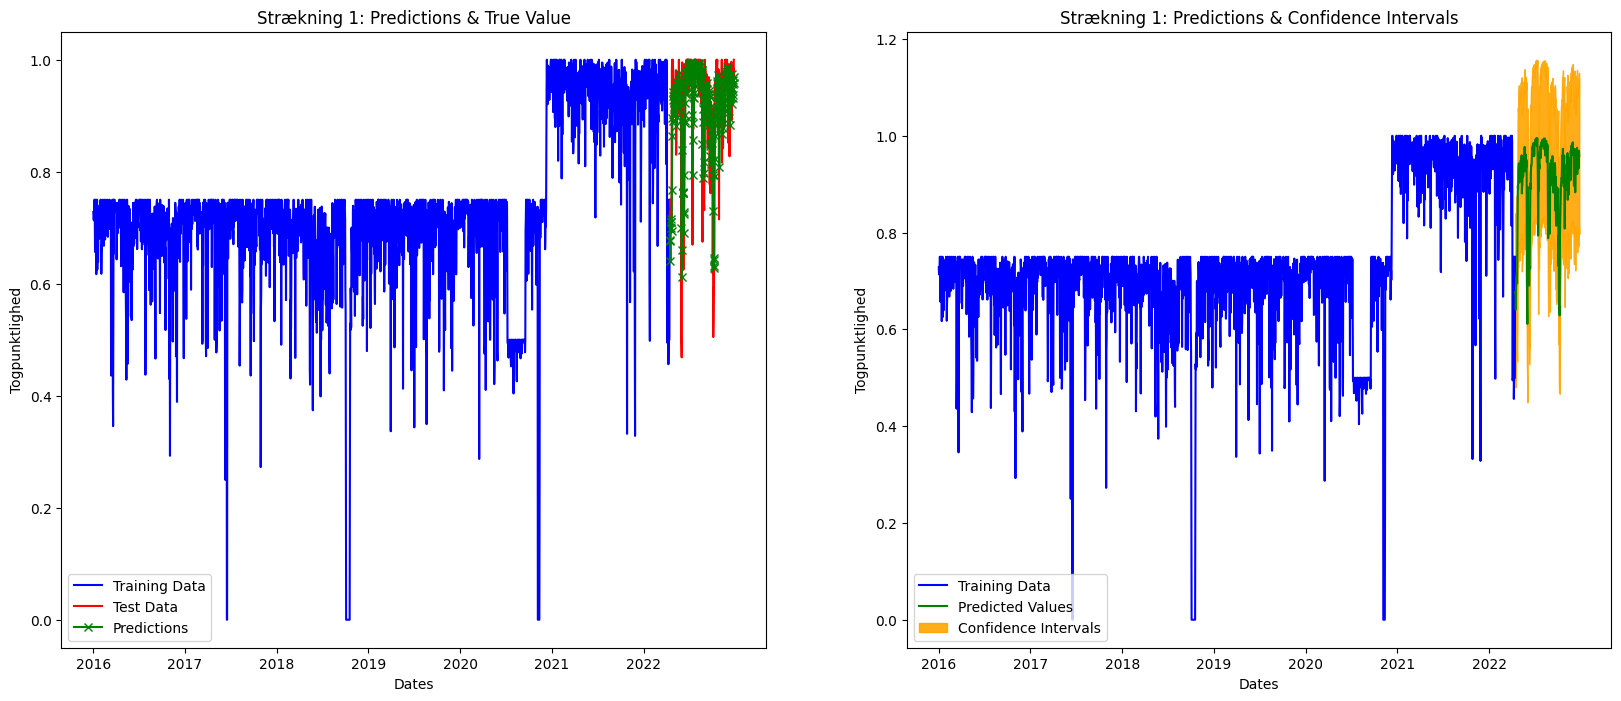

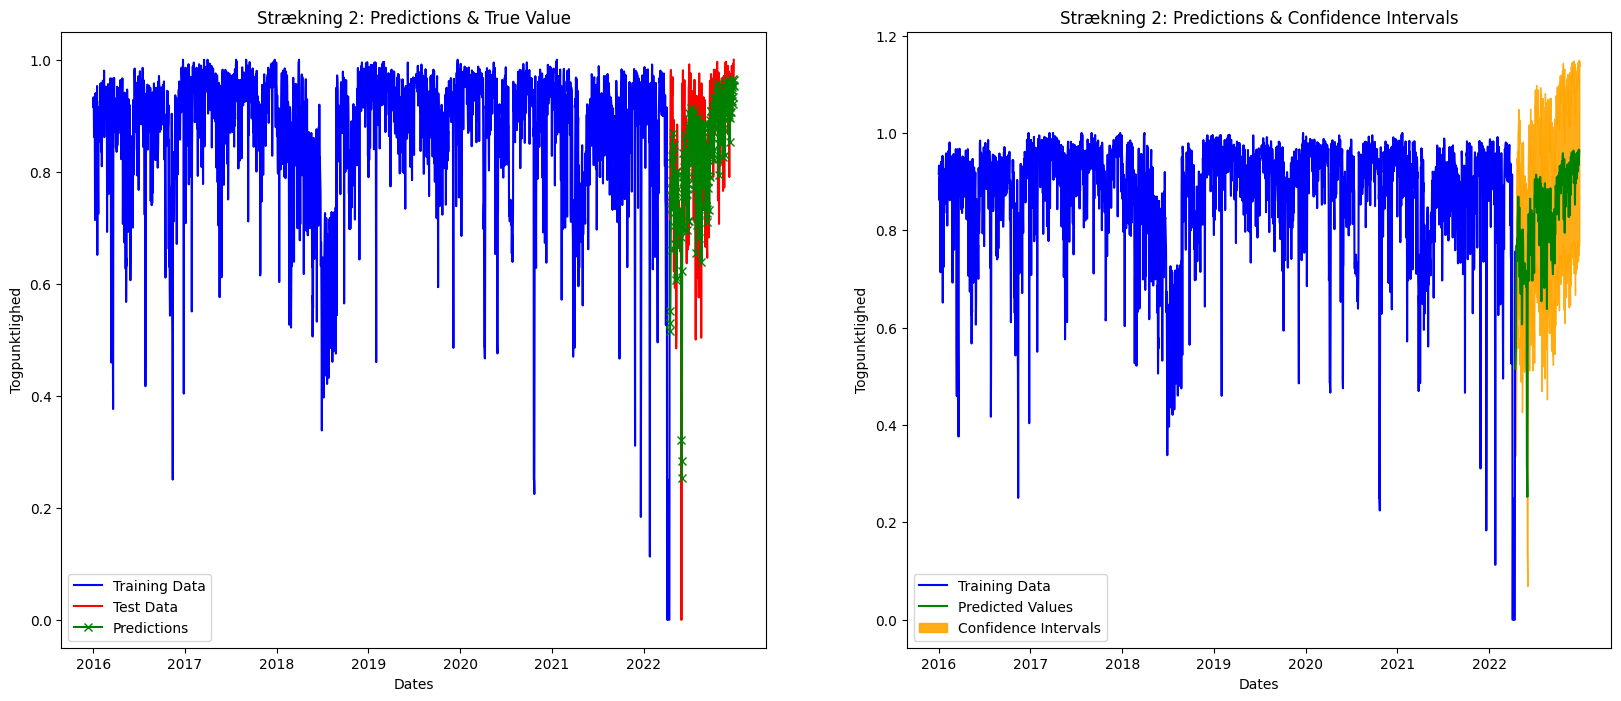

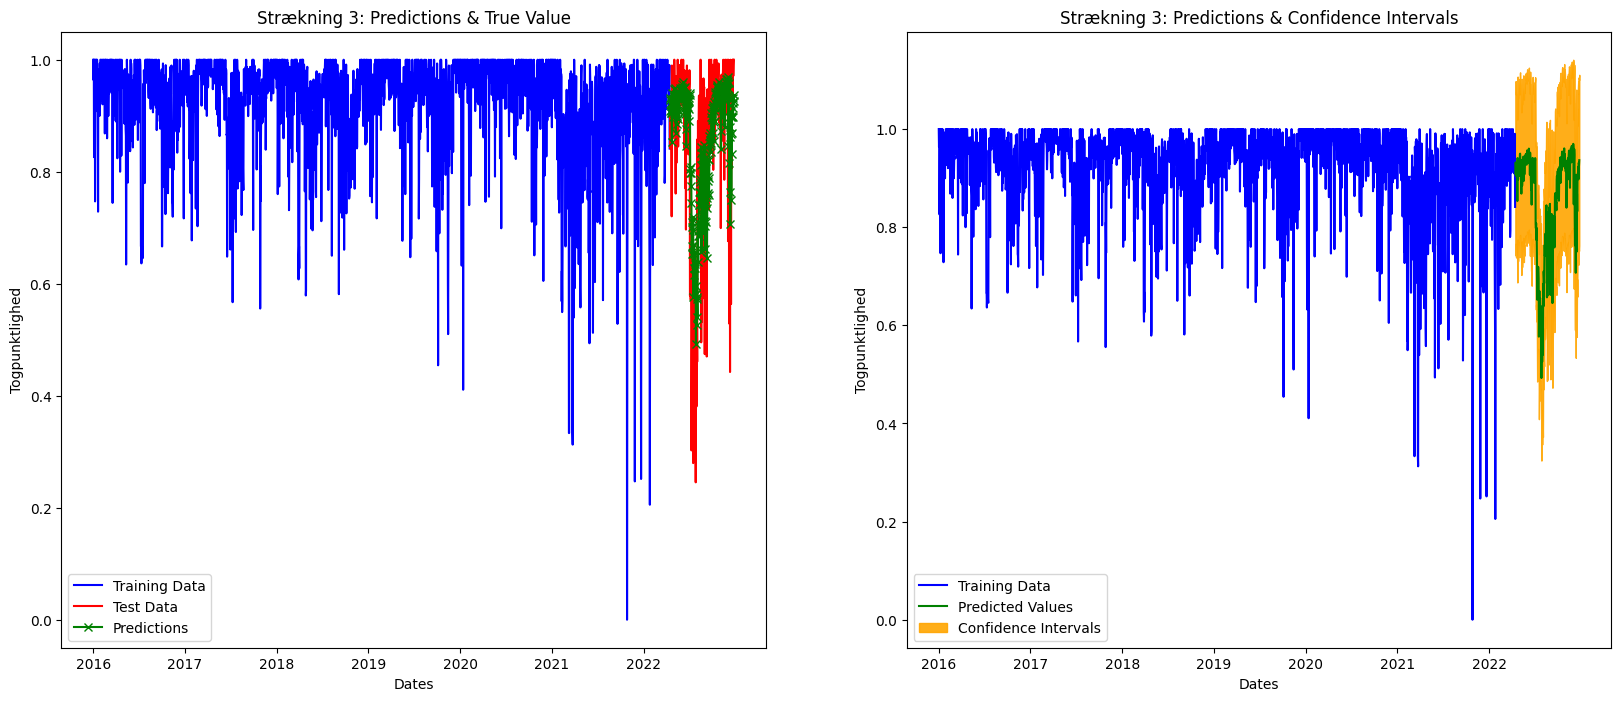

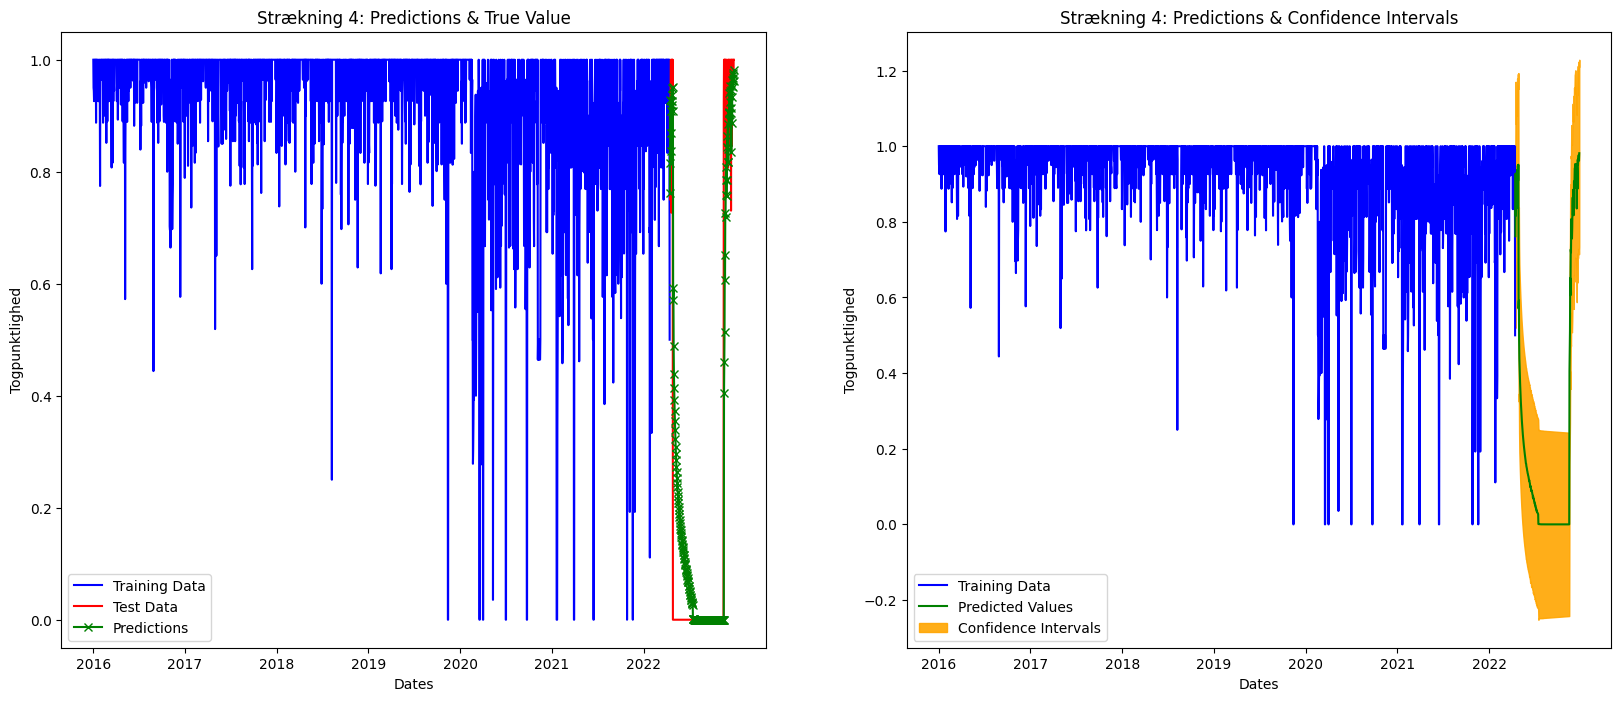

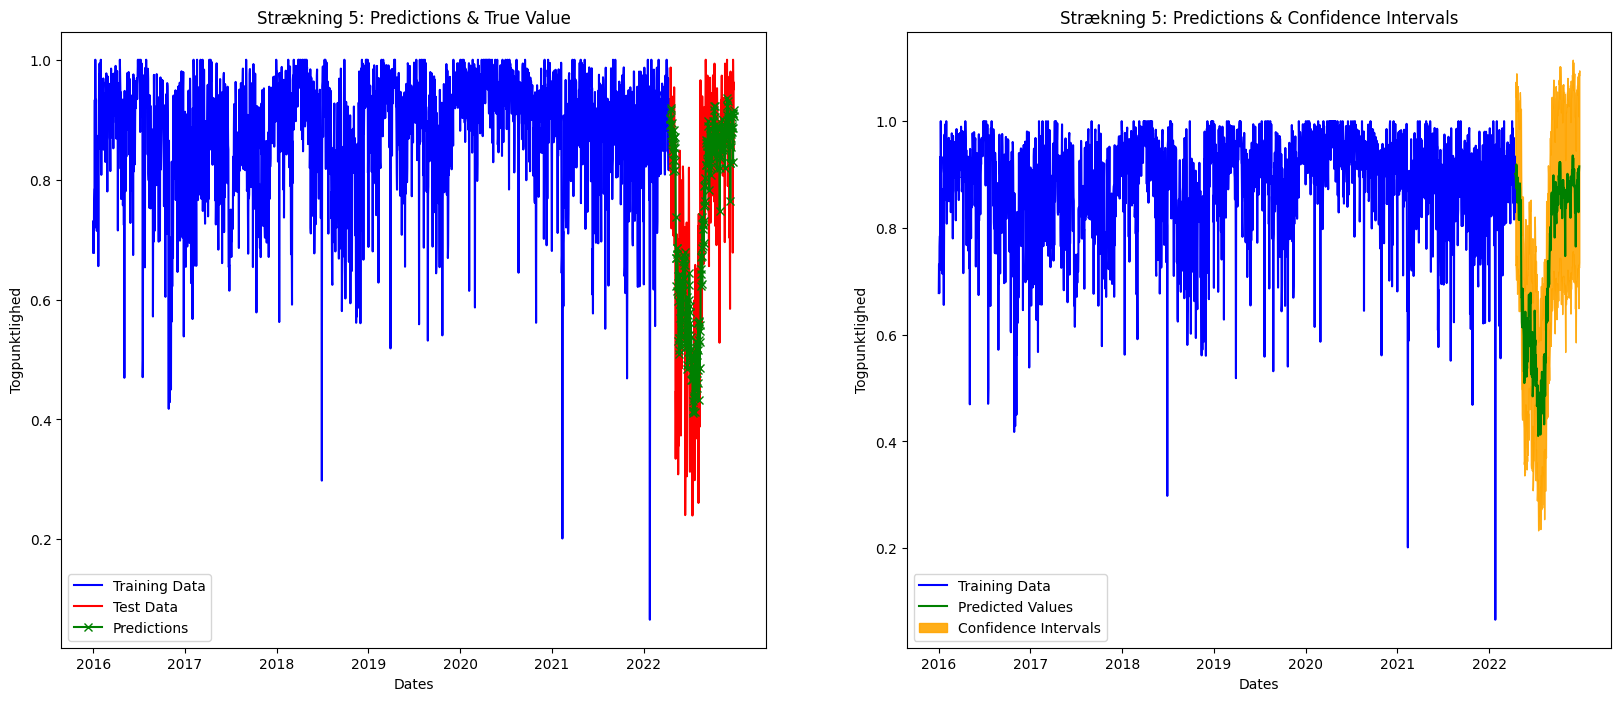

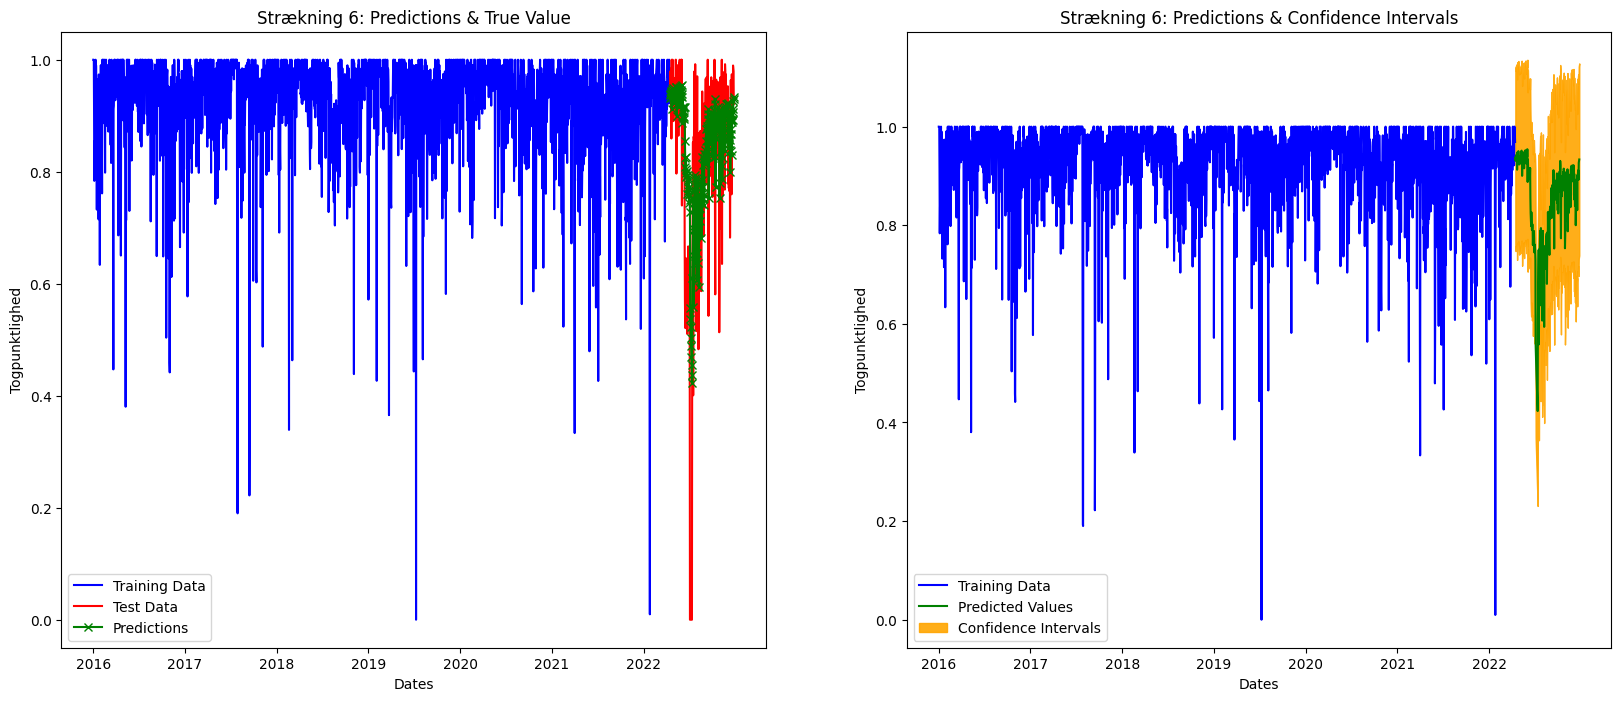

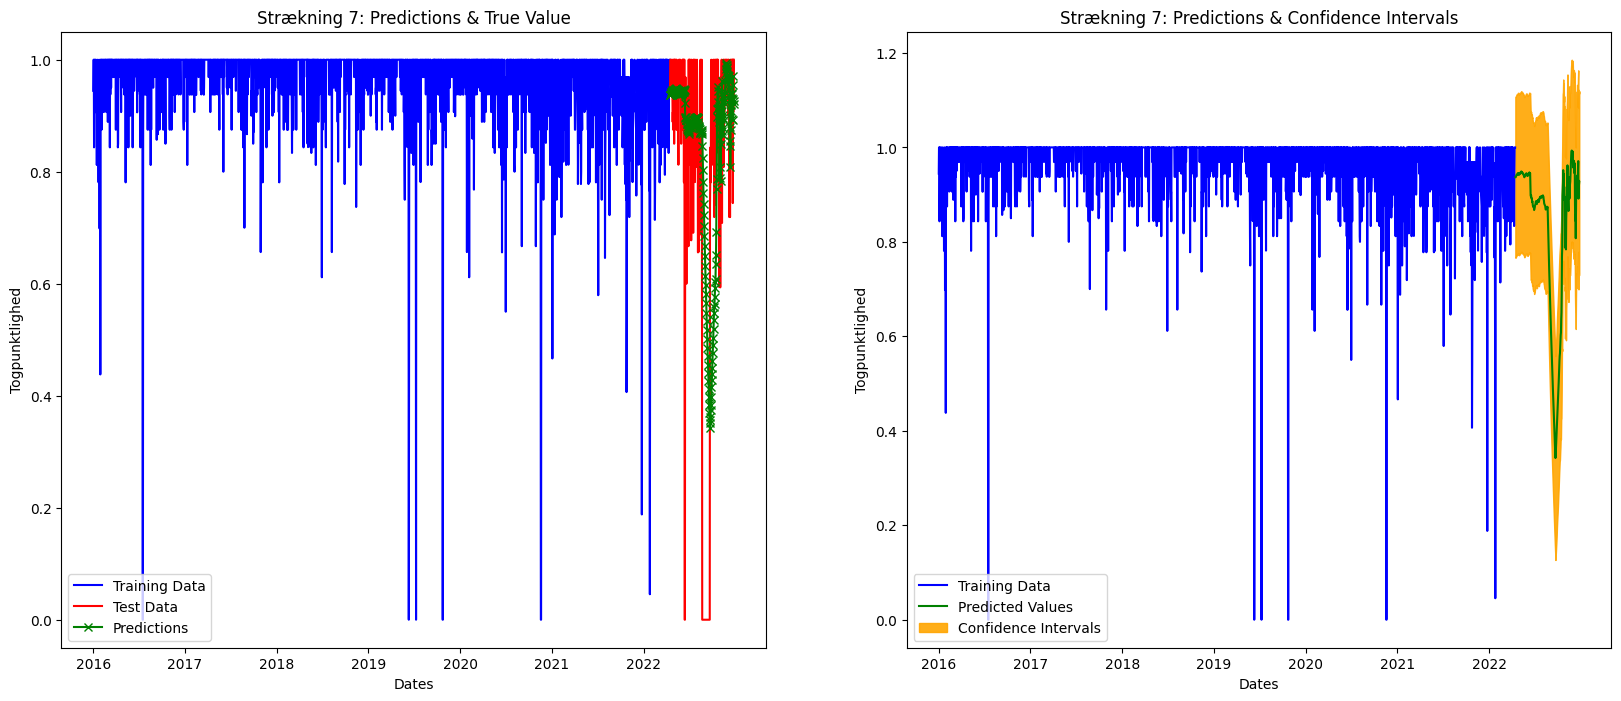

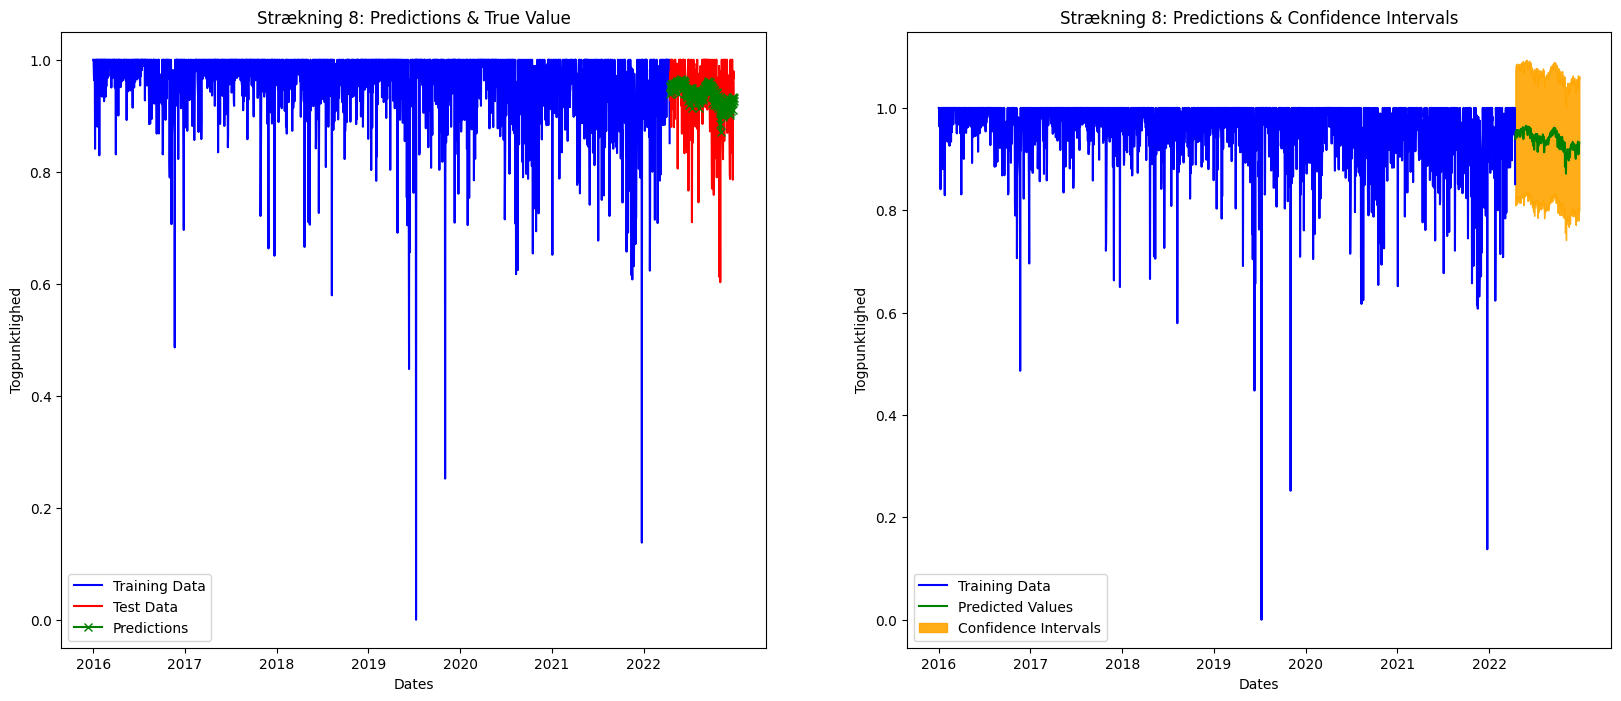

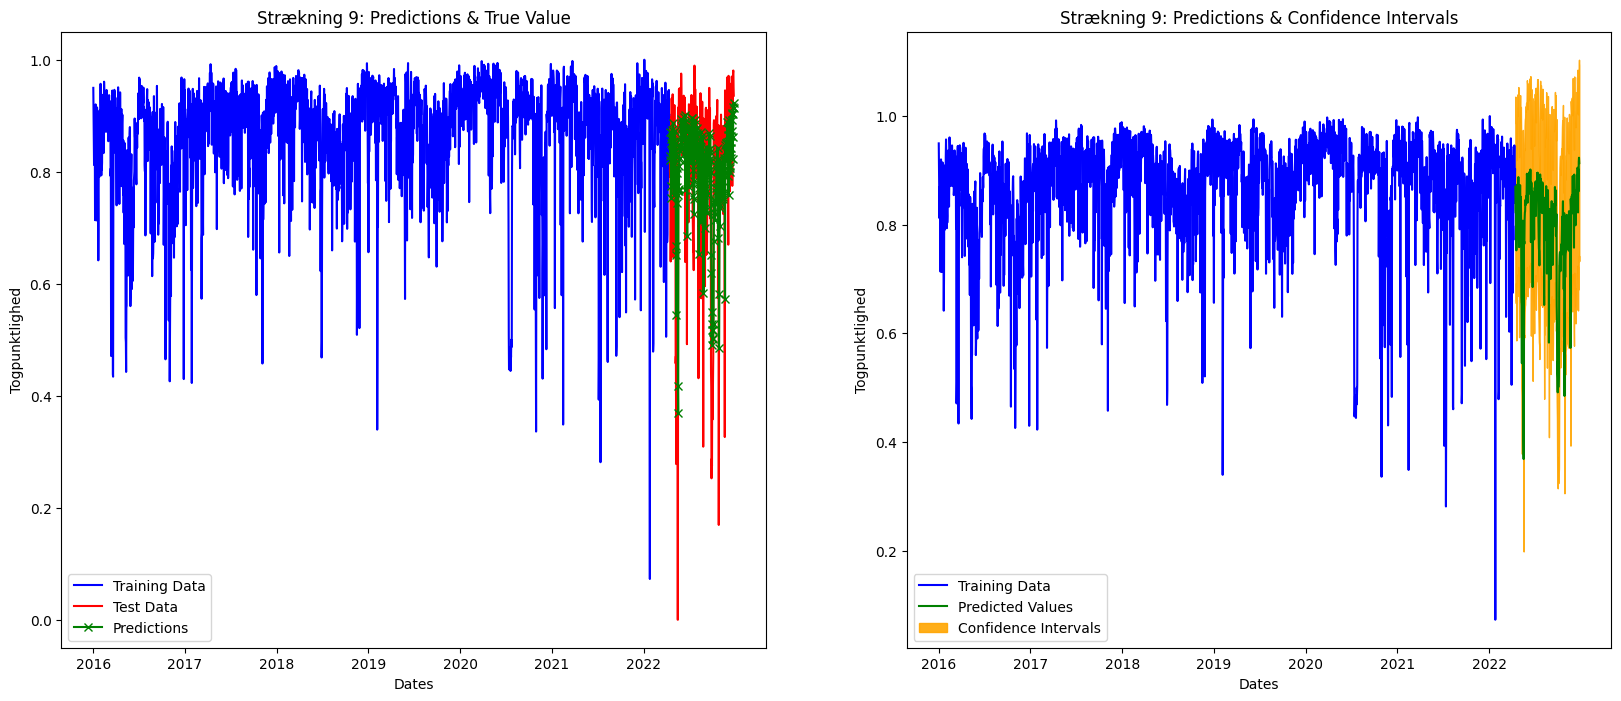

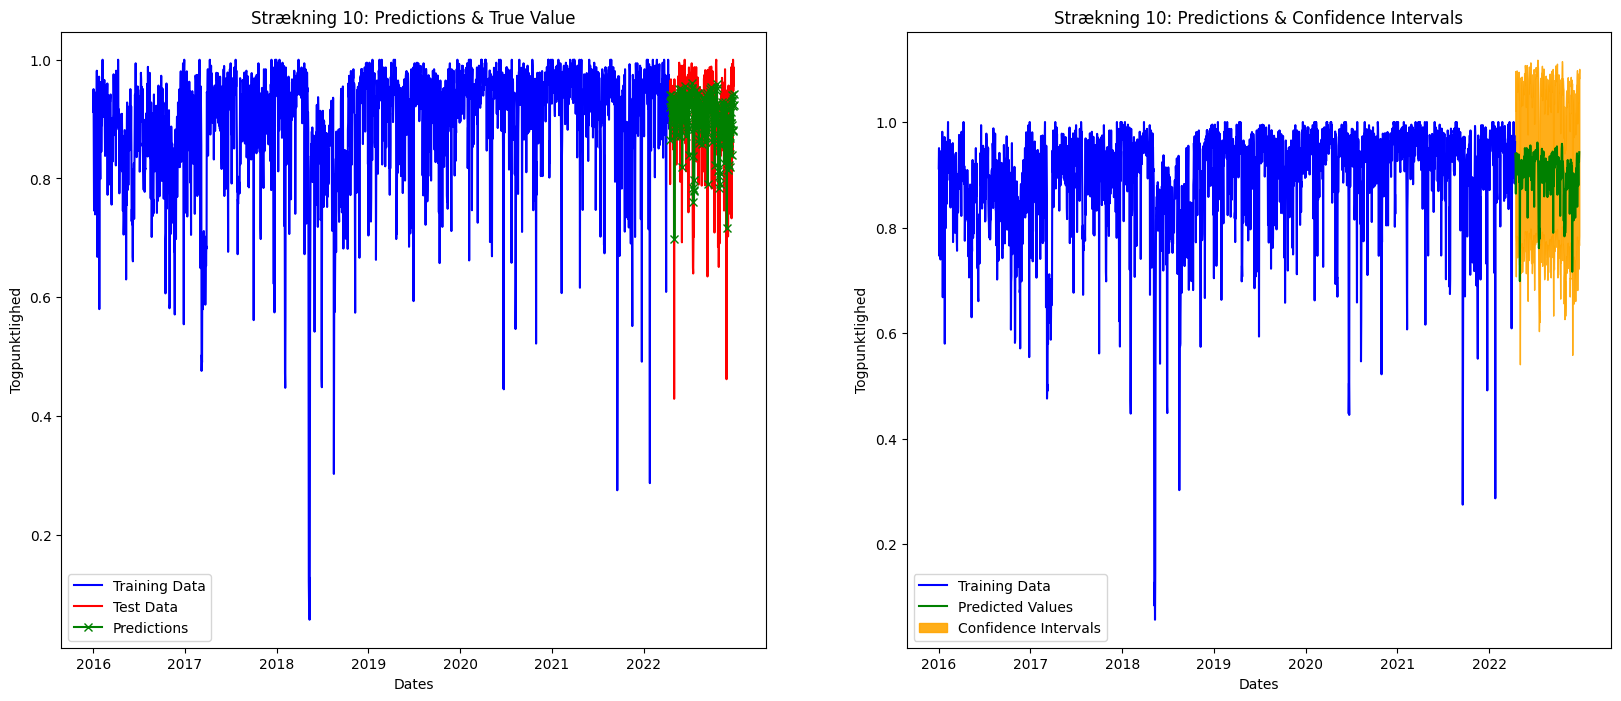

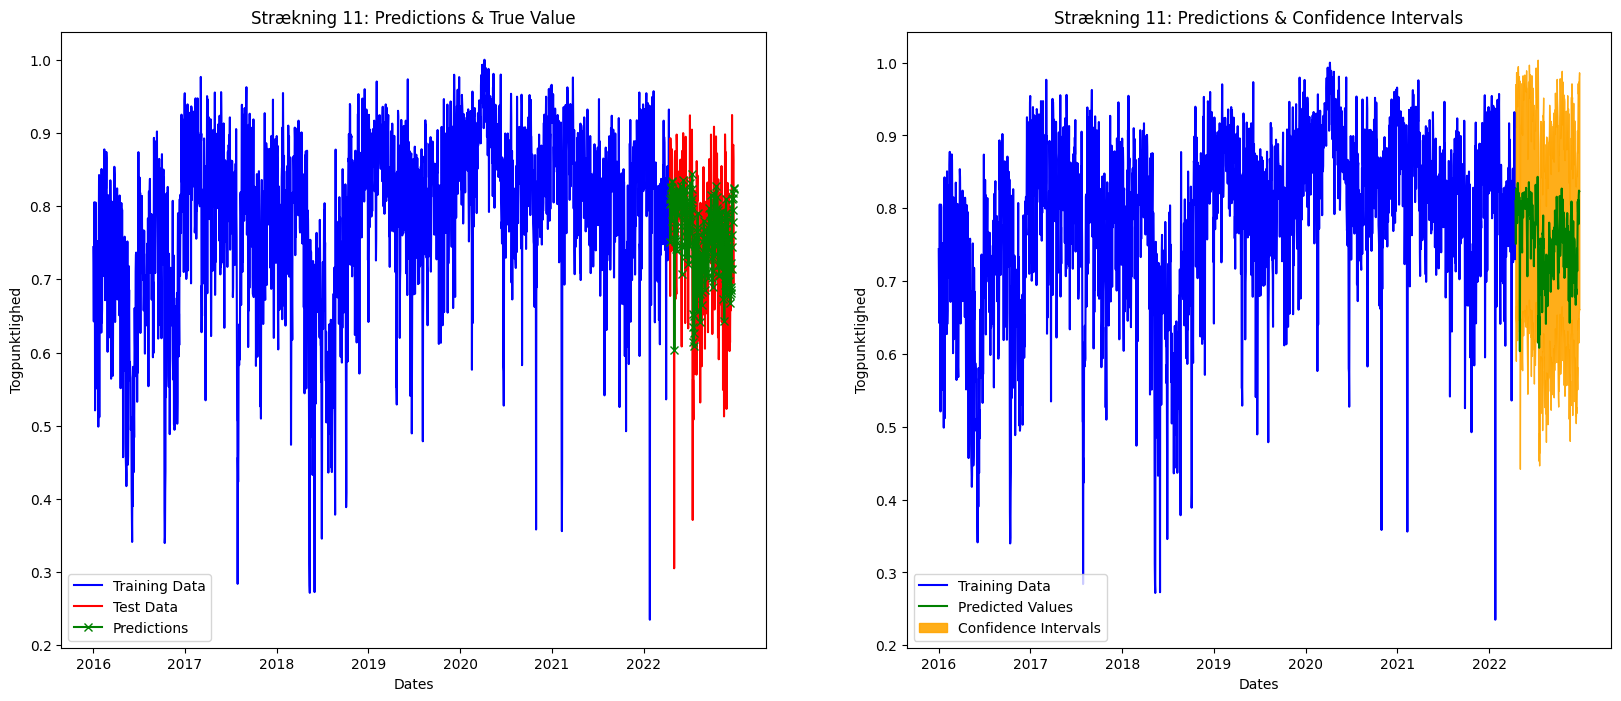

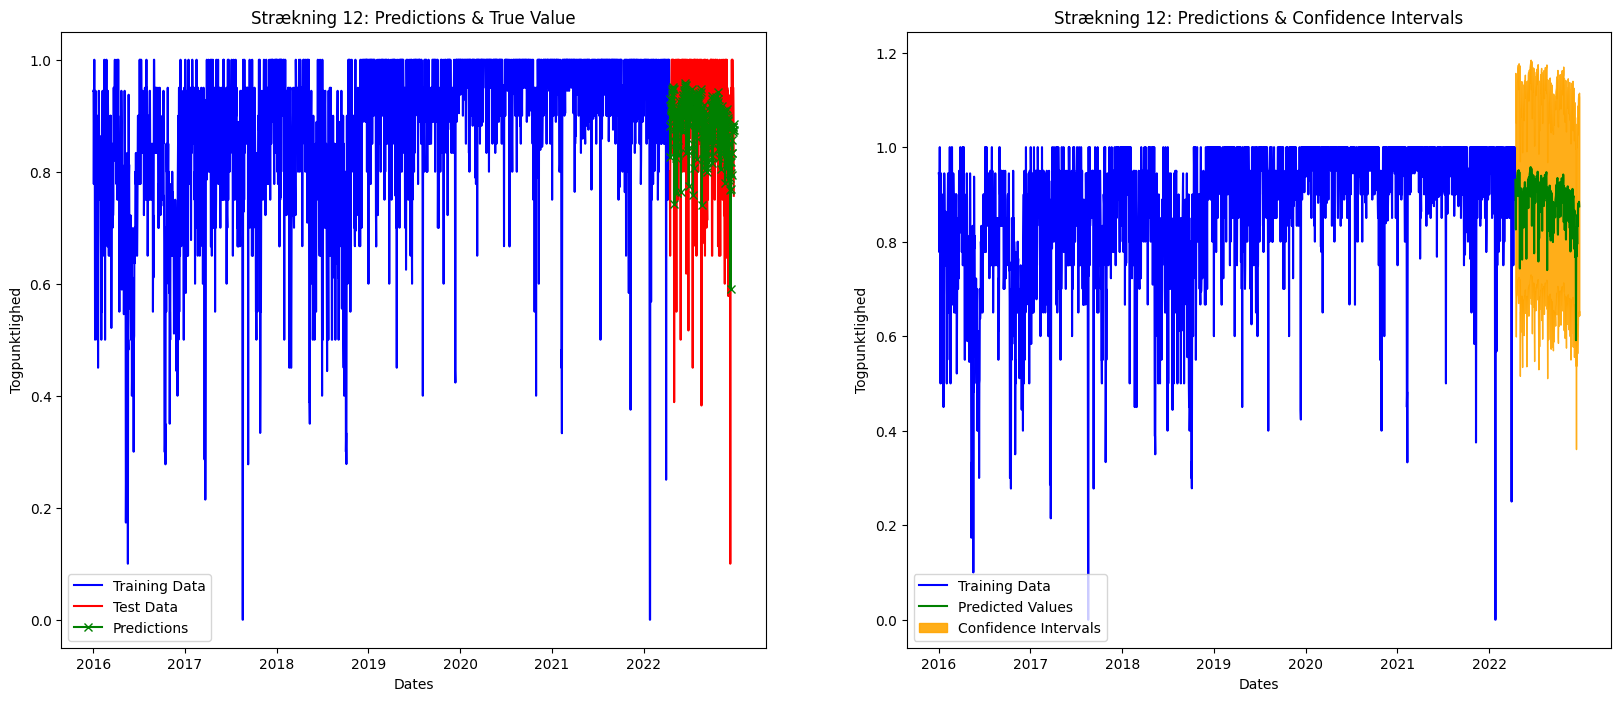

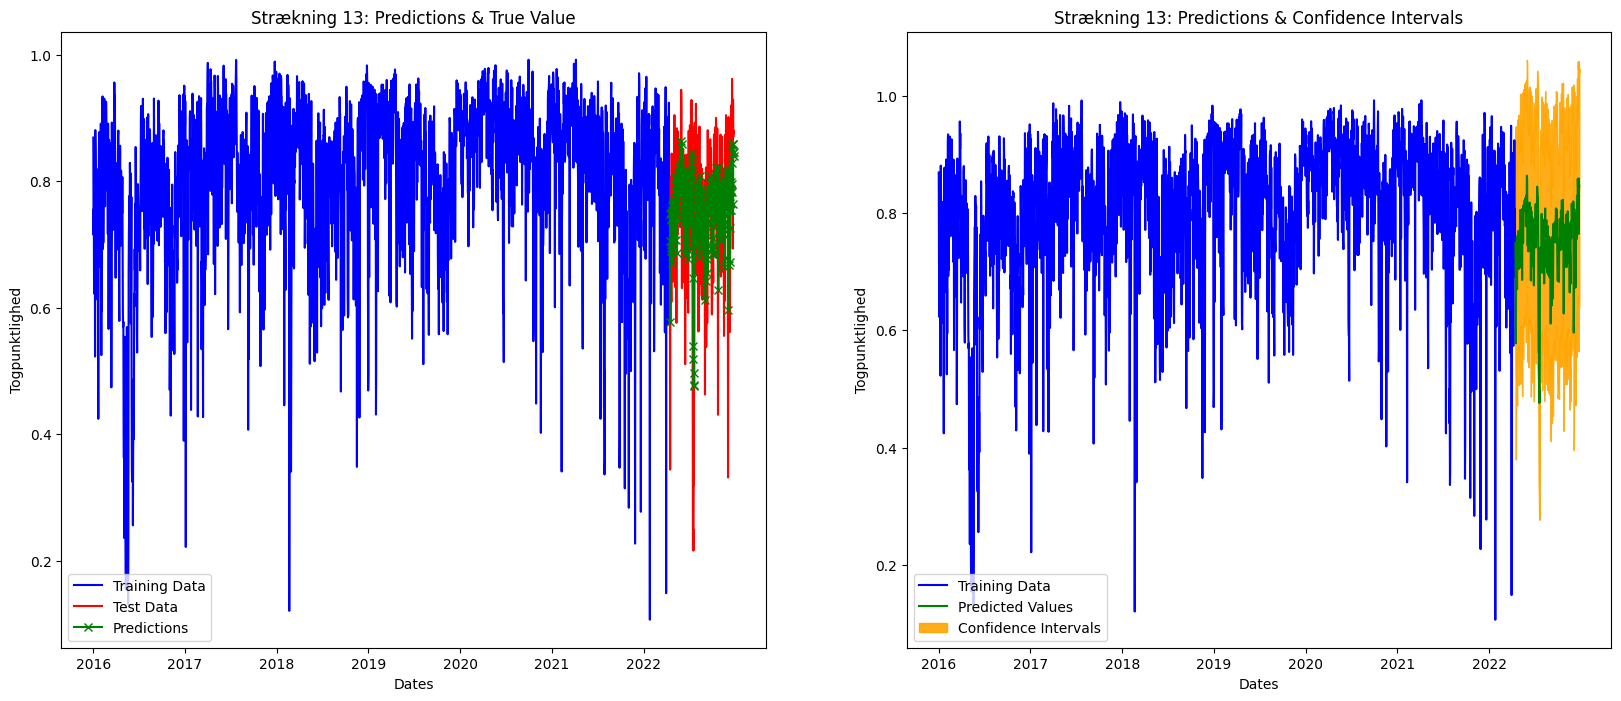

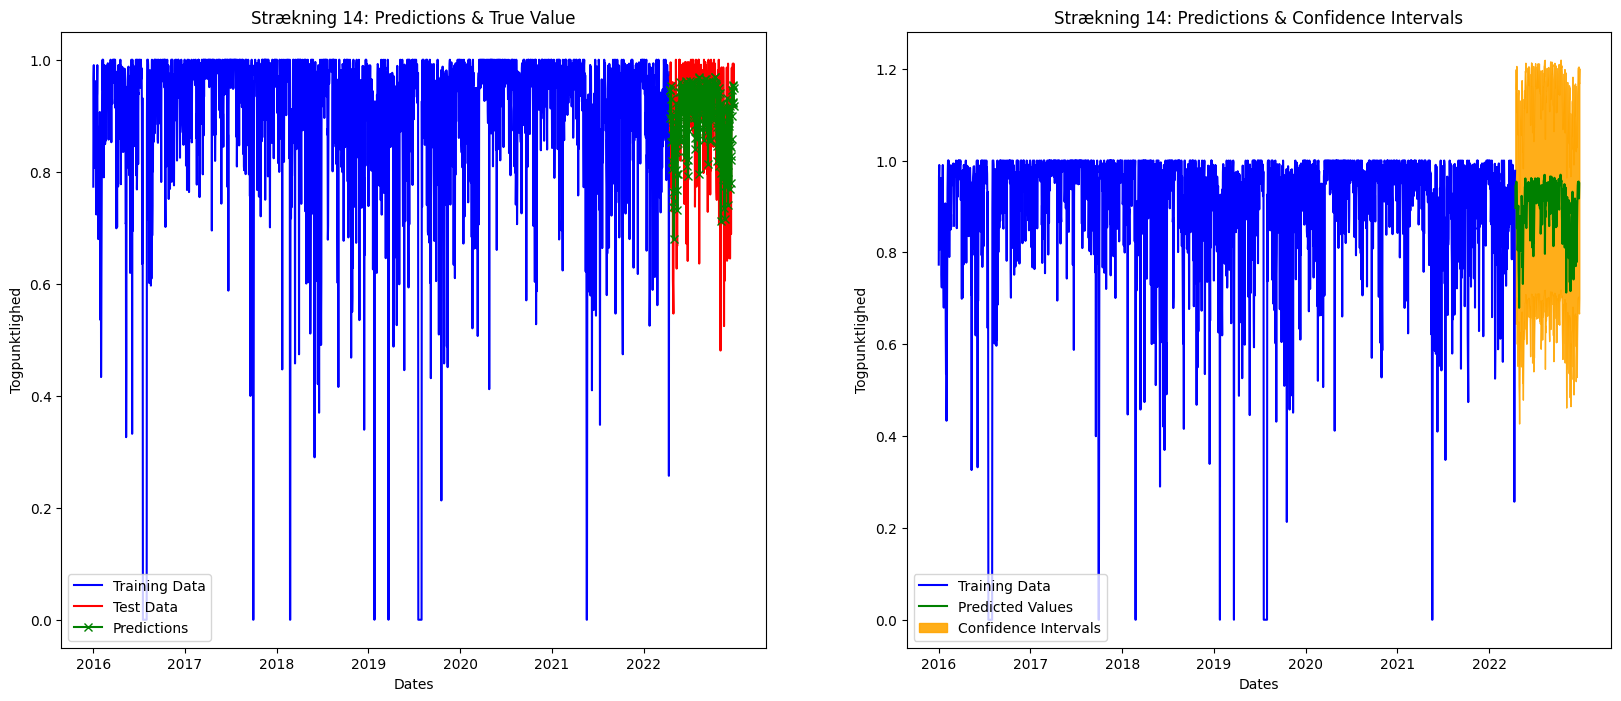

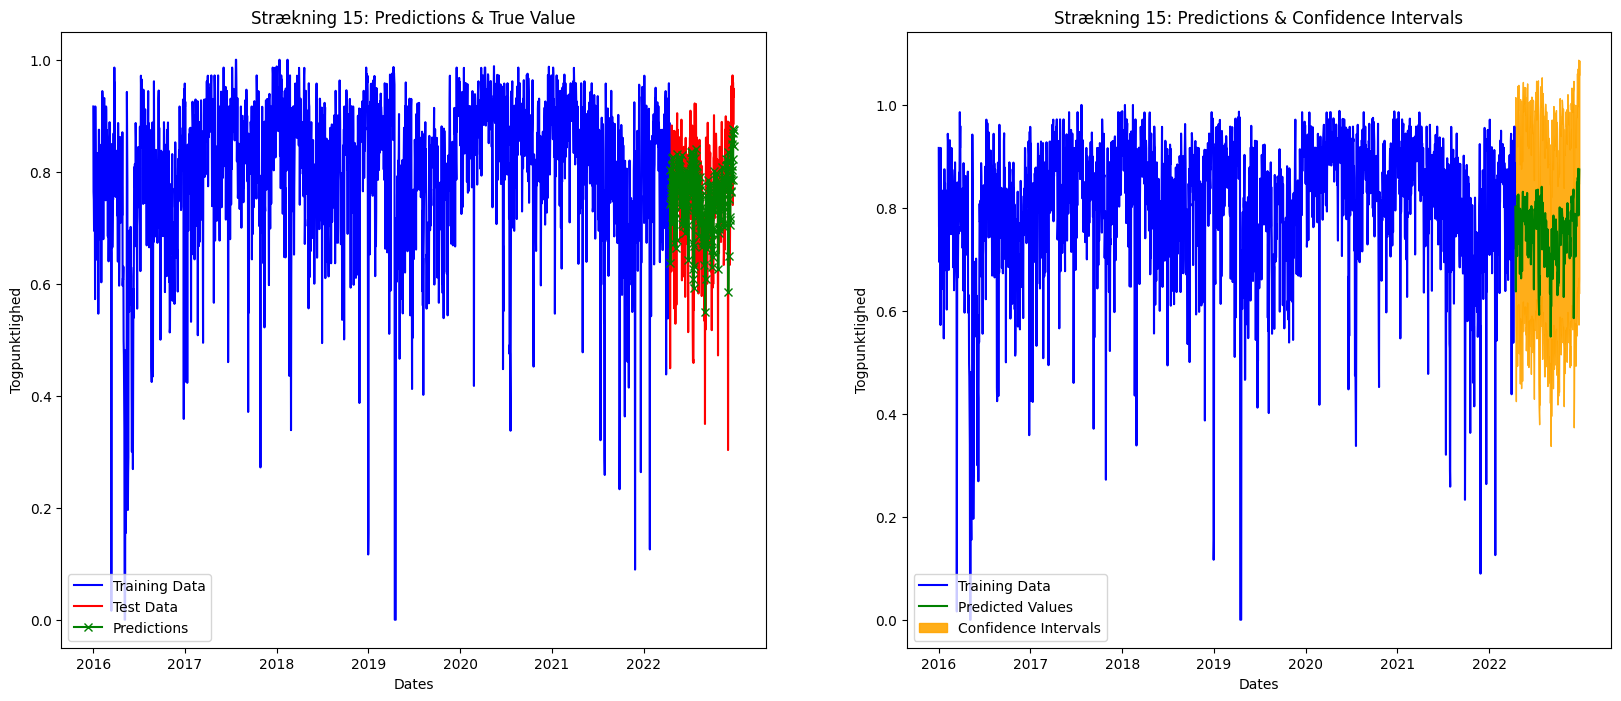

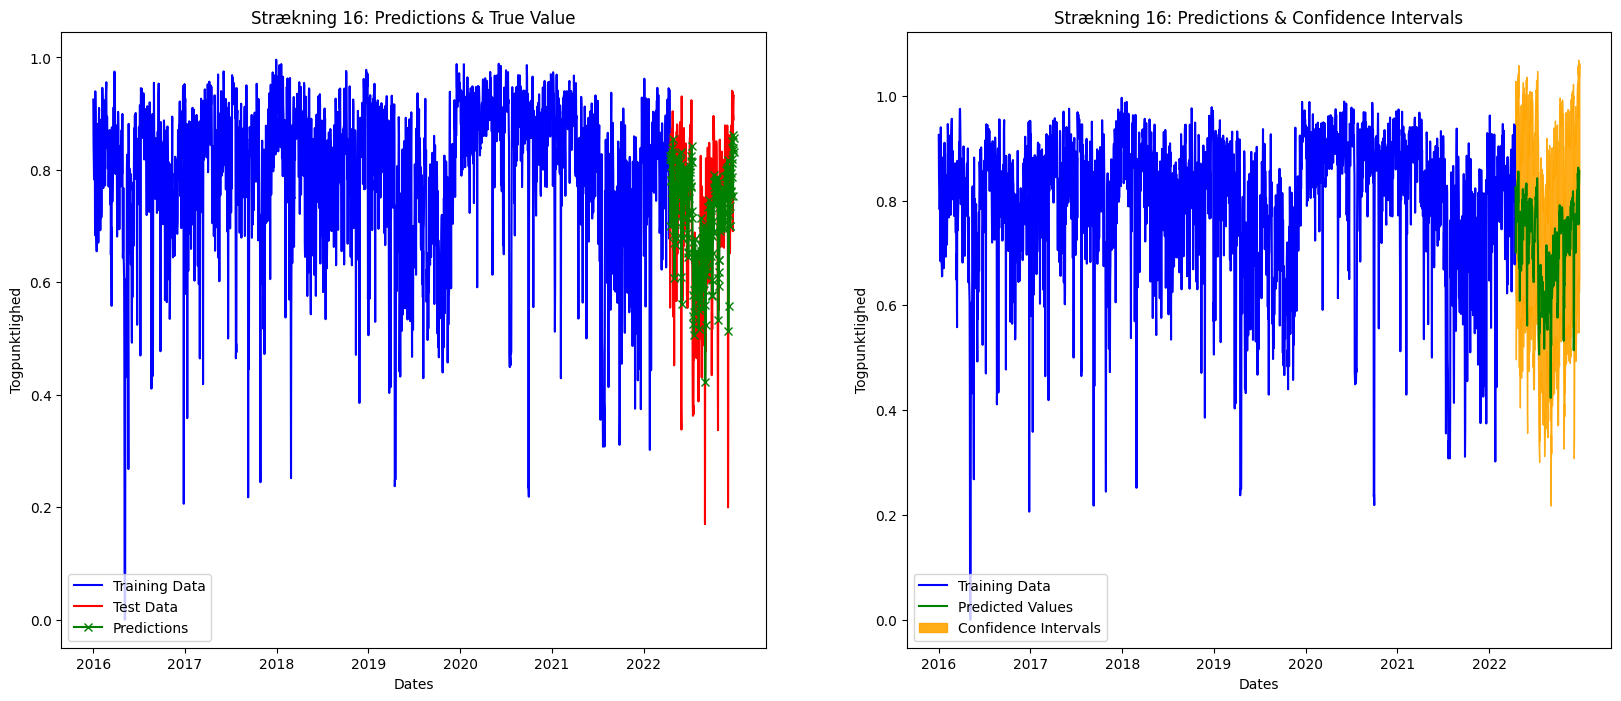

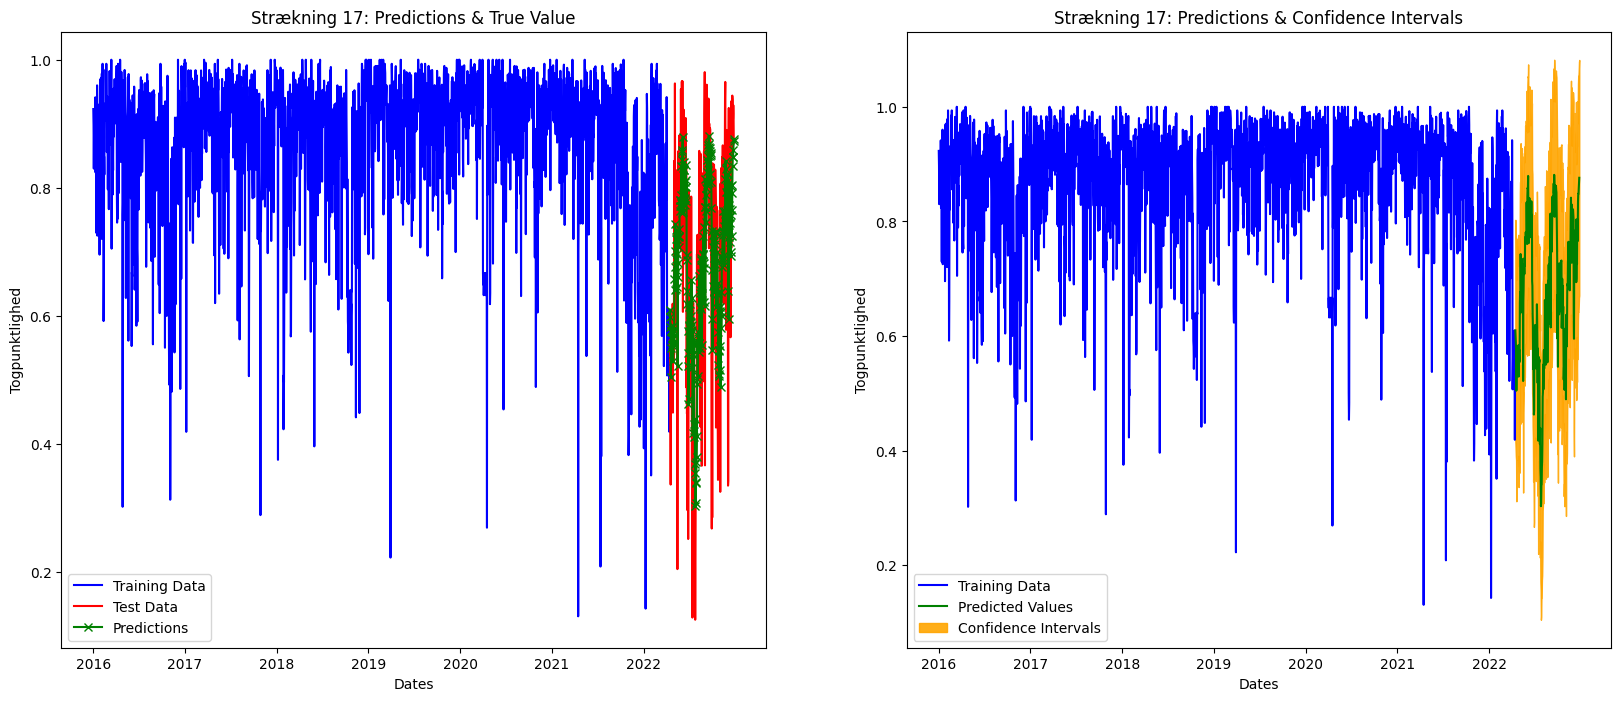

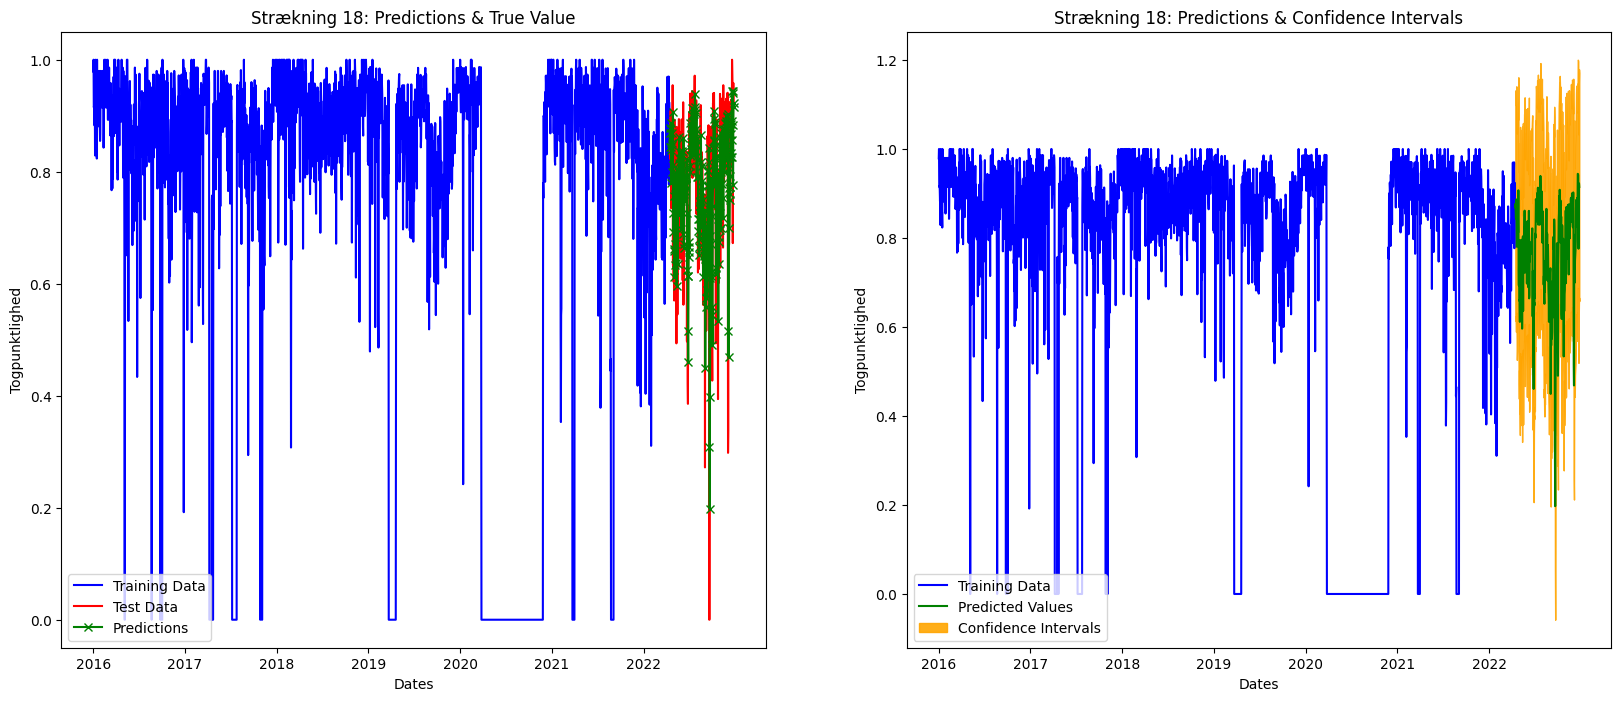

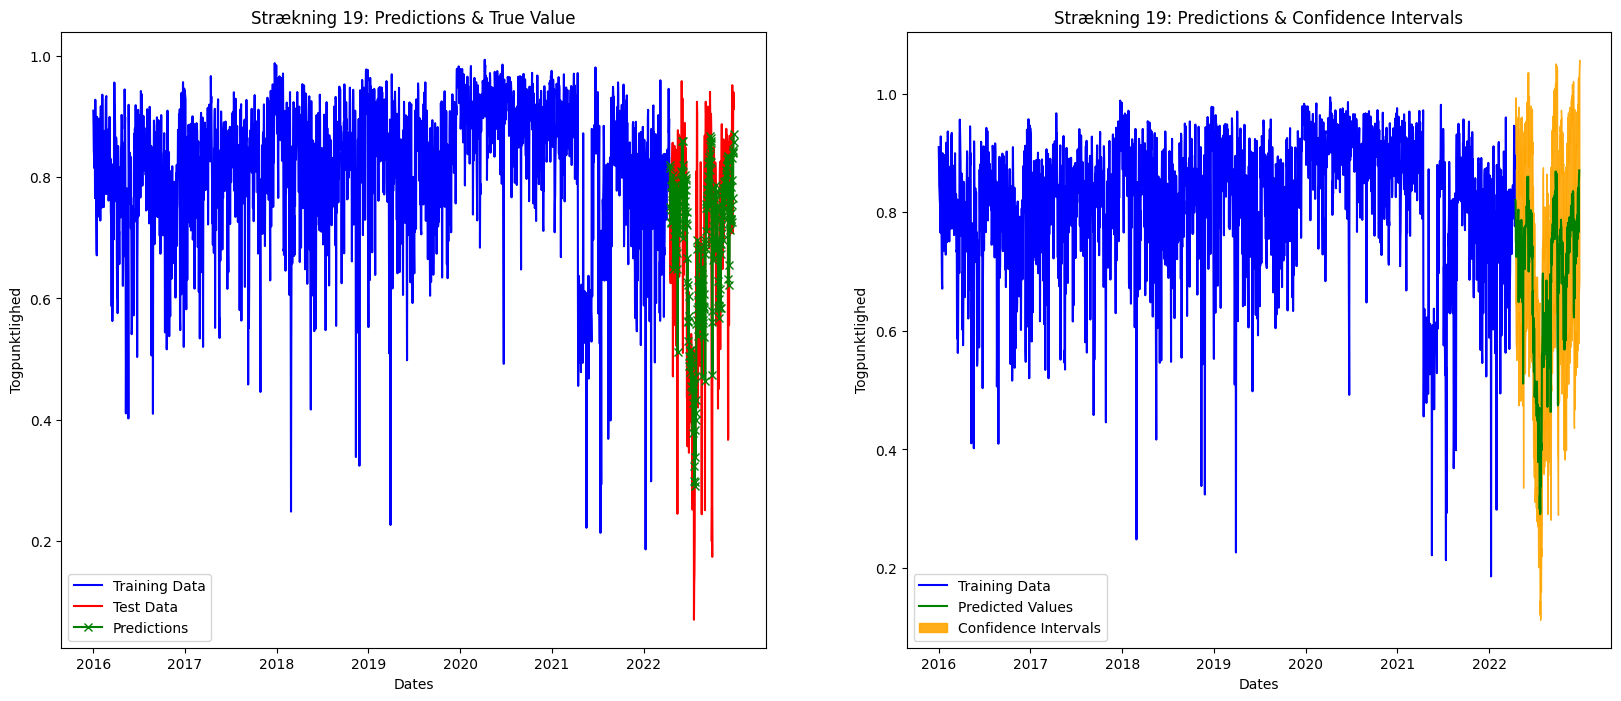

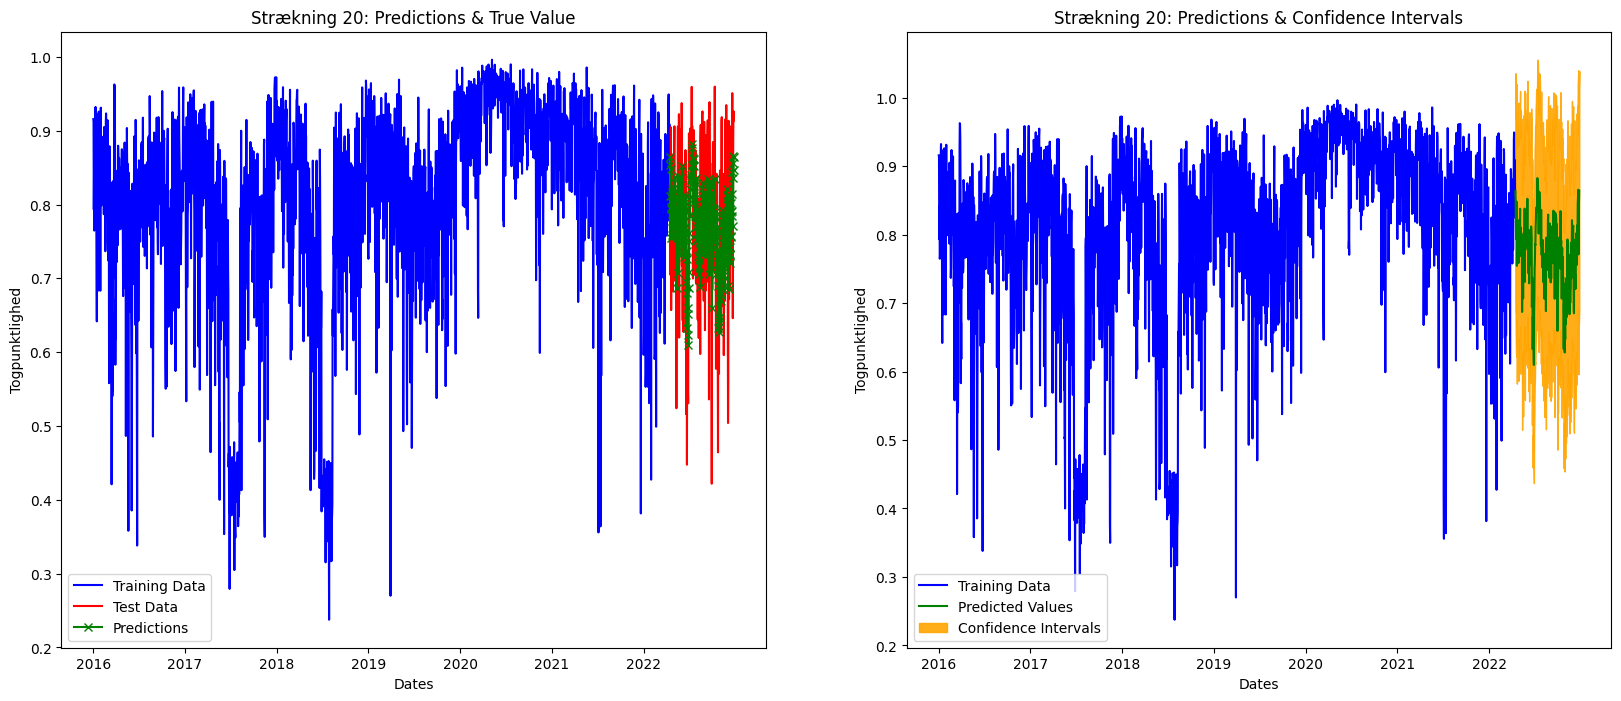

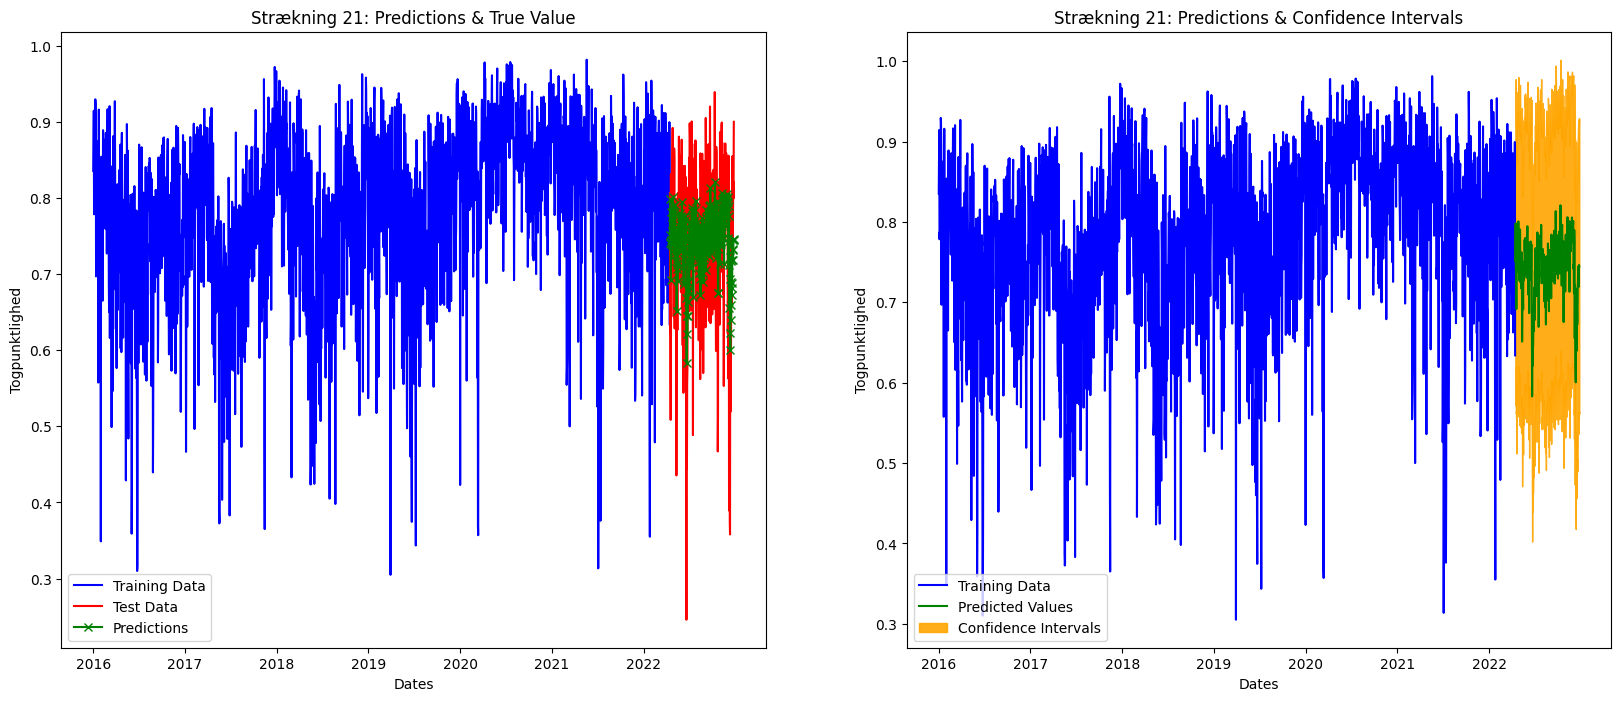

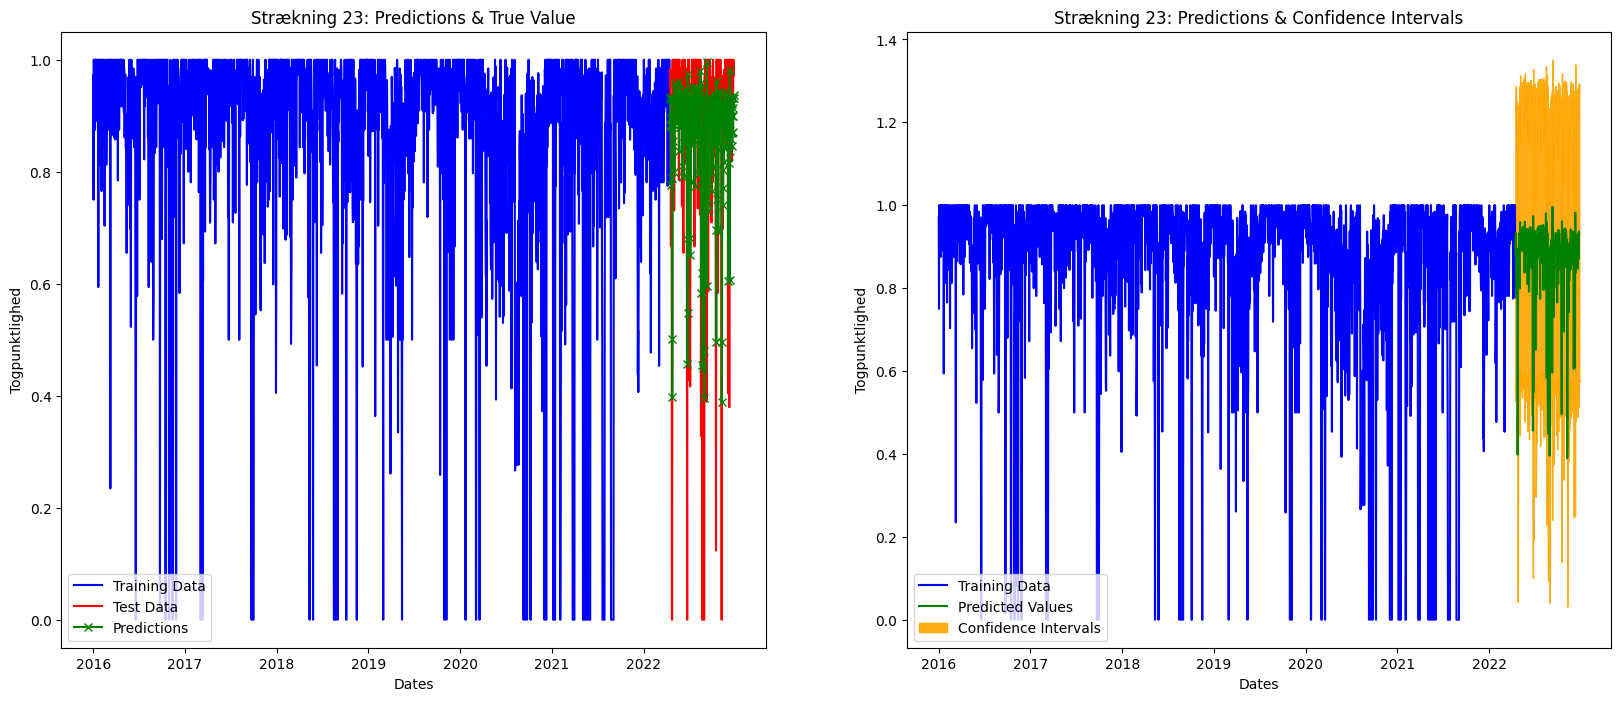

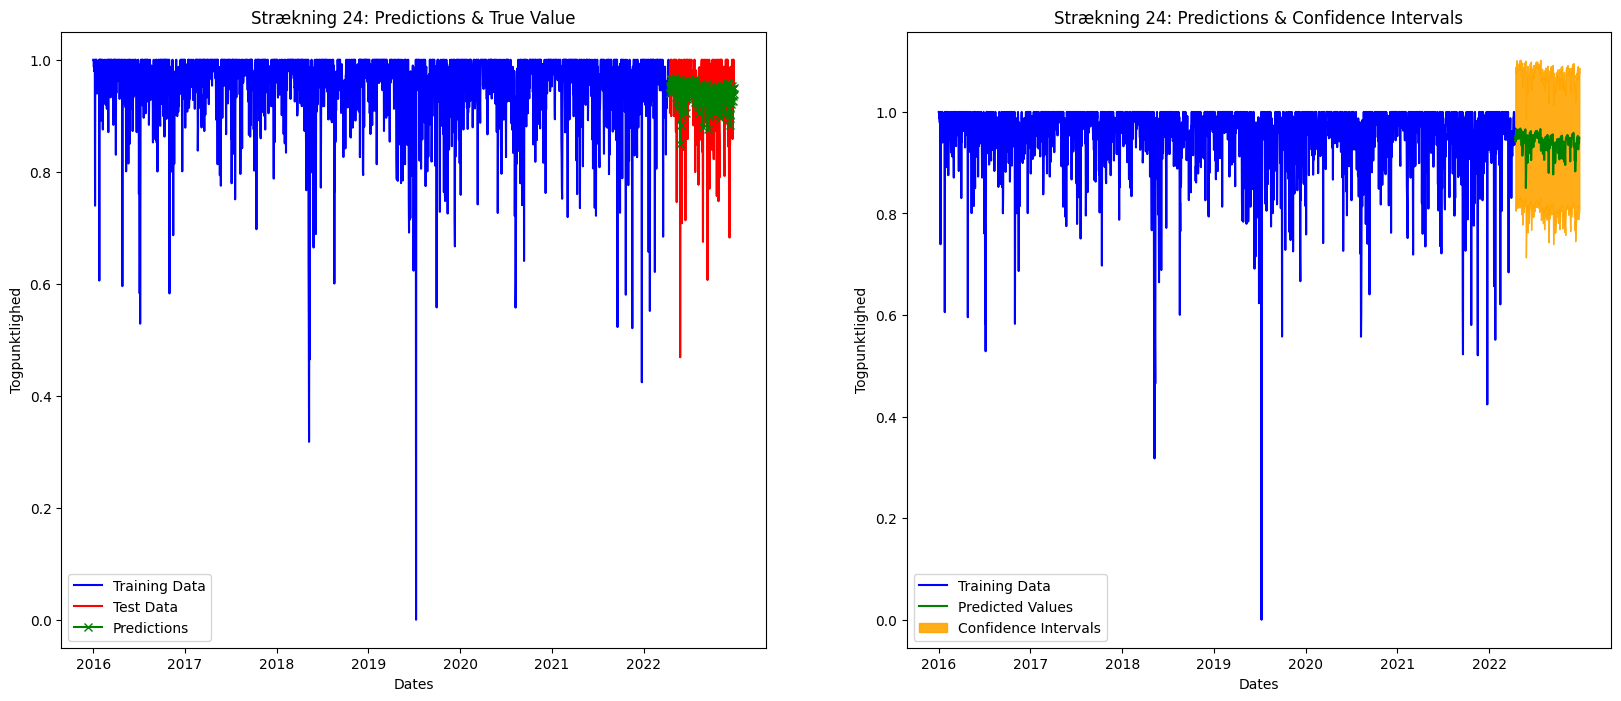

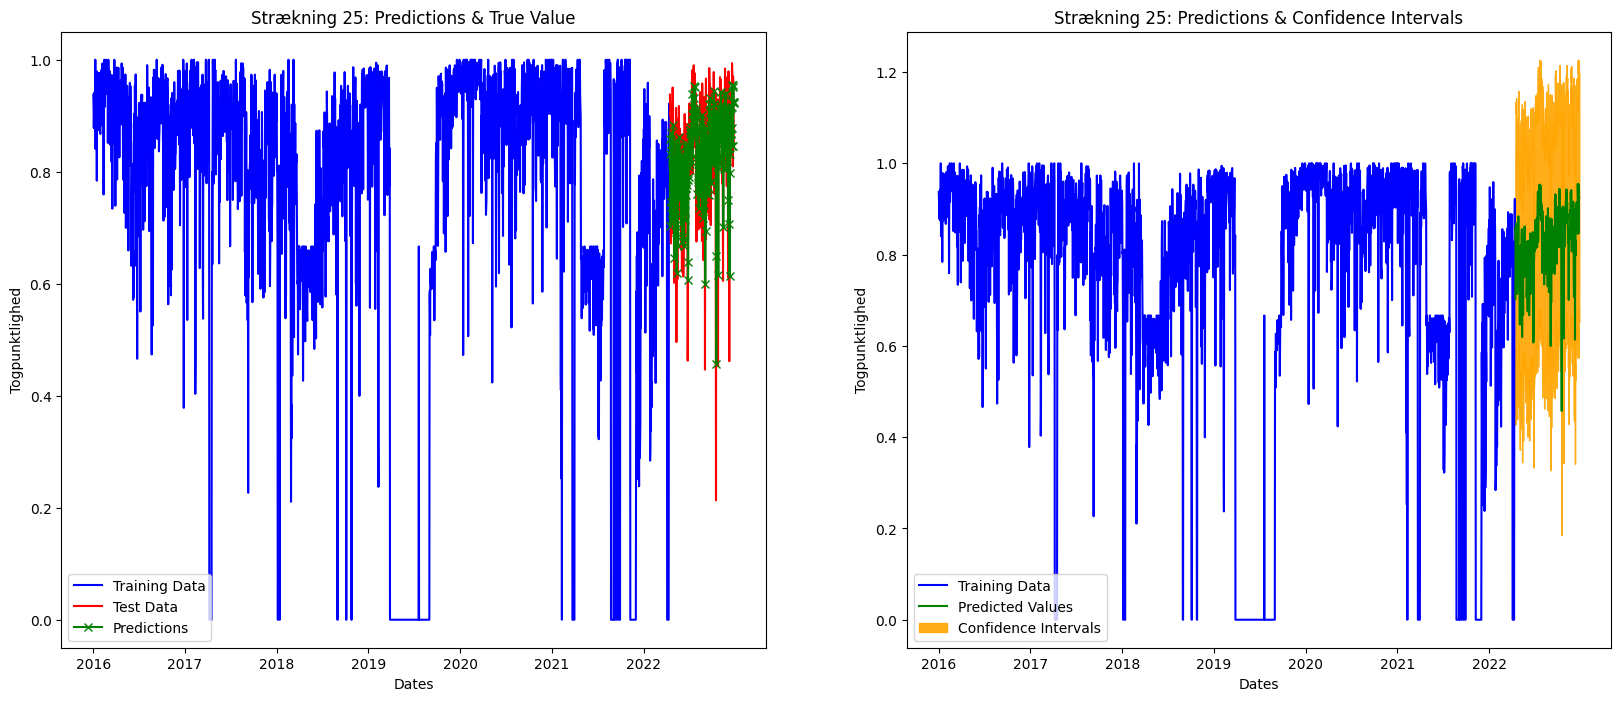

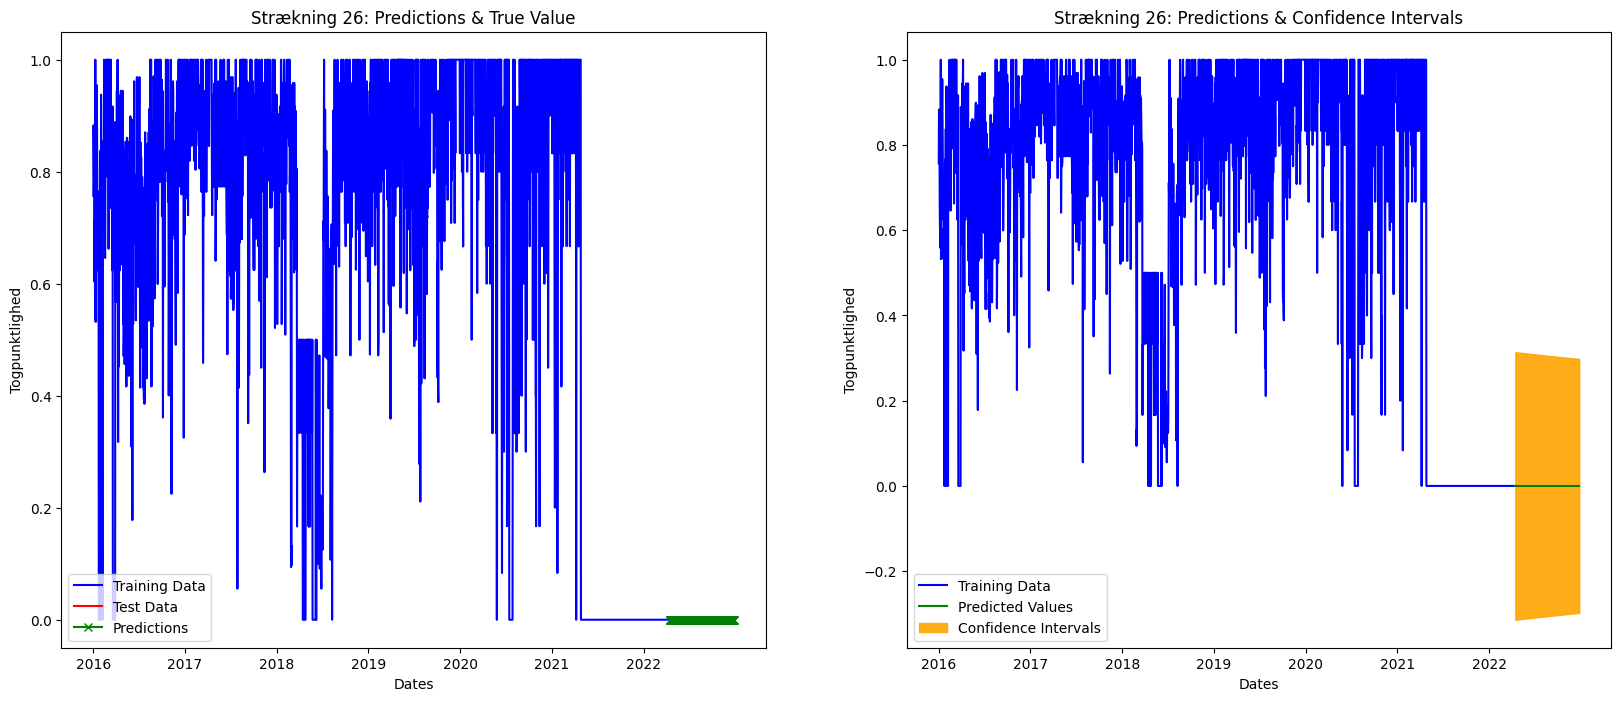

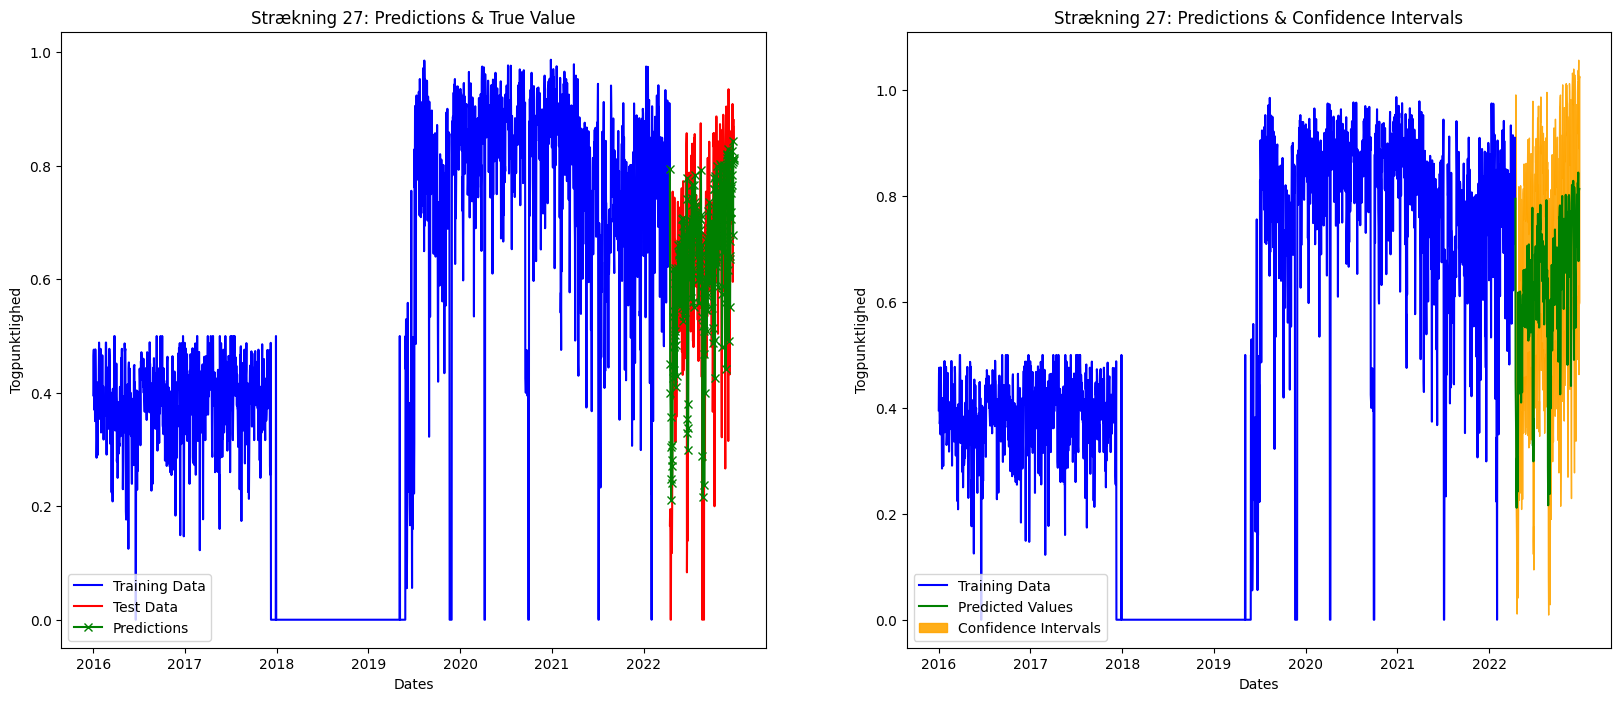

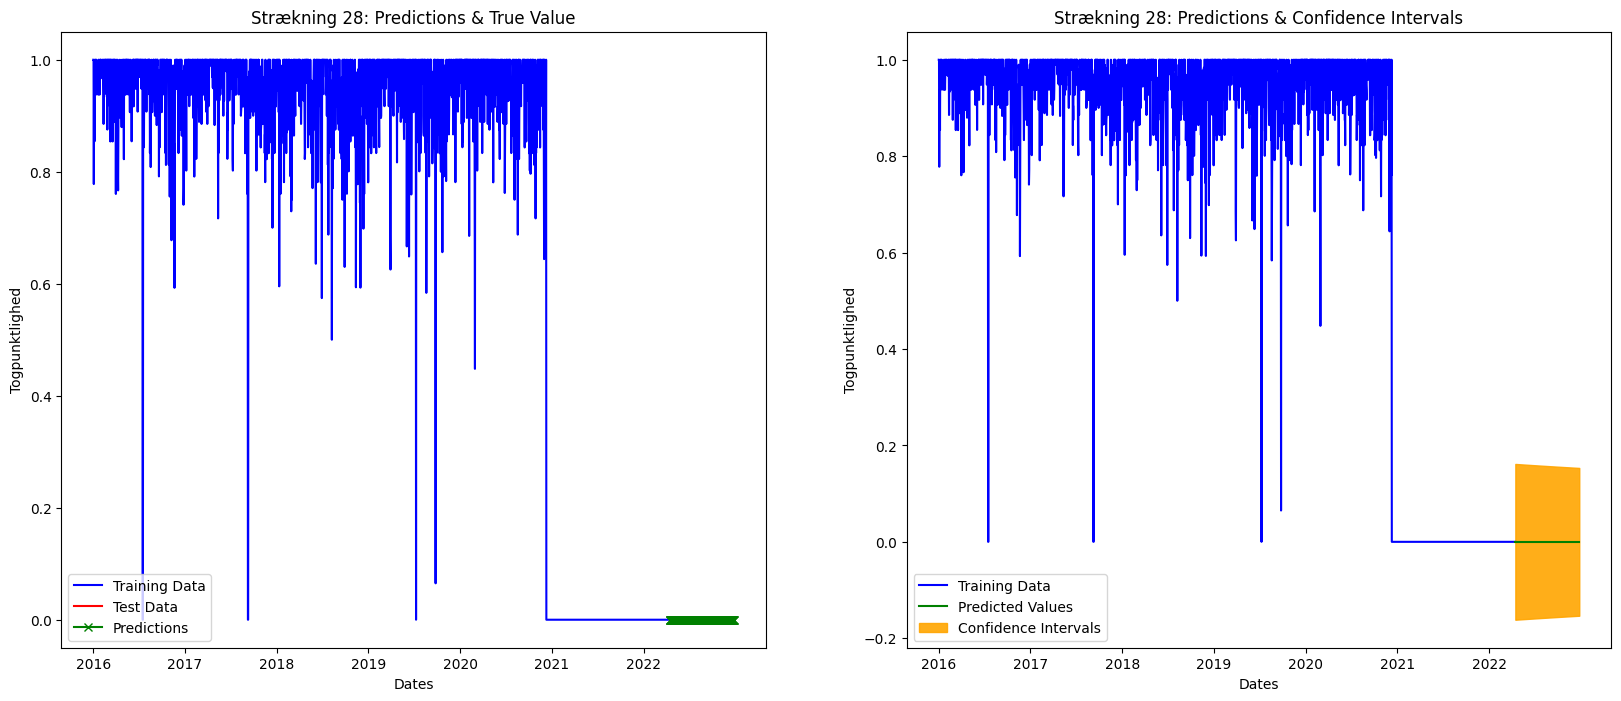

In [132]:
for strækning, results in data_each_strækning.items():
    y_train, y_test, forecasts, confidence_intervals, _, _ = results
    plotting_results(strækning, y_train, y_test, forecasts, confidence_intervals)

# Zero periods

In [122]:
y_train, y_test, *_ = data_each_strækning[4]

In [127]:
strækning4 = pd.concat([y_train,y_test])

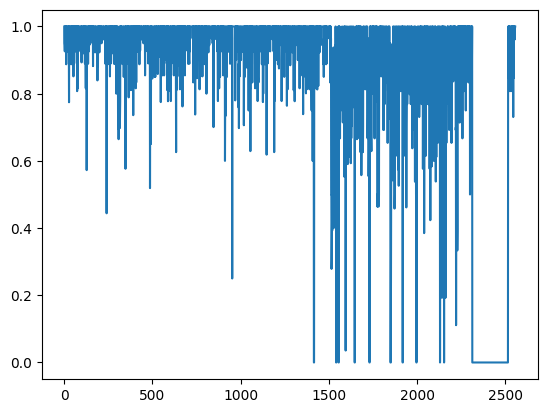

In [128]:
plt.plot(strækning4)

In [137]:
data[data['visualiseringskode'] == 4].groupby('dato').mean().iloc[-100:,:]

togpunktlighed  \
dato                         
2022-09-23          0.0000   
2022-09-24          0.0000   
2022-09-25          0.0000   
2022-09-26          0.0000   
2022-09-27          0.0000   
...                    ...   
2022-12-27          1.0000   
2022-12-28          1.0000   
2022-12-29          0.9615   
2022-12-30          1.0000   
2022-12-31          1.0000   

            koreplan_antal_planlagte_unik_tognr_togpkt_myldretid  \
dato                                                               
2022-09-23                                                0.0      
2022-09-24                                                0.0      
2022-09-25                                                0.0      
2022-09-26                                                0.0      
2022-09-27                                                0.0      
...                                                       ...      
2022-12-27                                                6.0      
2022-12-28                                                6.0      
2022-12-29                                                6.0      
2022-12-30                                                6.0      
2022-12-31                                                0.0      

            koreplan_antal_planlagte_prod_kode_myldretid  \
dato                                                       
2022-09-23                                           0.0   
2022-09-24                                           0.0   
2022-09-25                                           0.0   
2022-09-26                                           0.0   
2022-09-27                                           0.0   
...                                                  ...   
2022-12-27                                           1.0   
2022-12-28                                           1.0   
2022-12-29                                           1.0   
2022-12-30                                           1.0   
2022-12-31                                           0.0   

            koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid  \
dato                                                                  
2022-09-23                                                0.0         
2022-09-24                                                0.0         
2022-09-25                                                0.0         
2022-09-26                                                0.0         
2022-09-27                                                0.0         
...                                                       ...         
2022-12-27                                                0.0         
2022-12-28                                                0.0         
2022-12-29                                                0.0         
2022-12-30                                                0.0         
2022-12-31                                                0.0         

            koreplan_antal_planlagte_unik_tognr_alle_myldretid  \
dato                                                             
2022-09-23                                                0.0    
2022-09-24                                                0.0    
2022-09-25                                                0.0    
2022-09-26                                                0.0    
2022-09-27                                                0.0    
...                                                       ...    
2022-12-27                                                6.0    
2022-12-28                                                6.0    
2022-12-29                                                6.0    
2022-12-30                                                6.0    
2022-12-31                                                0.0    

            koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid  \
dato                                                                   
2022-09-23                  

In [145]:
from datetime import datetime
datetime_str = '2022-09-26'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d')


In [146]:
datetime_object

datetime.datetime(2022, 9, 26, 0, 0)

In [156]:
data_reset_index = data.reset_index()
result = data_reset_index[(data_reset_index['visualiseringskode'] == 4) & (data_reset_index['dato'] == datetime_object)]

In [157]:
result

dato  togpunktlighed  \
191946 2022-09-26             0.0   
191952 2022-09-26             0.0   

        koreplan_antal_planlagte_unik_tognr_togpkt_myldretid  \
191946                                                0.0      
191952                                                0.0      

        koreplan_antal_planlagte_prod_kode_myldretid  \
191946                                           0.0   
191952                                           0.0   

        koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid  \
191946                                                0.0         
191952                                                0.0         

        koreplan_antal_planlagte_unik_tognr_alle_myldretid  \
191946                                                0.0    
191952                                                0.0    

        koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid  \
191946                                                0.0          
191952                                                0.0          

        koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid  \
191946                                                0.0           
191952                                                0.0           

        koreplan_antal_planlagte_togfoelge_under_5_min_myldretid  \
191946                                                0.0          
191952                                                0.0          

        koreplan_gns_planlagte_togfoelg_alle_min_myldretid  ...  dsb_tgf_fte  \
191946                                                0.0   ...          0.0   
191952                                                0.0   ...          0.0   

        dsb_tgf_raadighed  dsb_tgf_sygdom  dsb_tgf_relative_sygdom  \
191946                0.0             0.0                      0.0   
191952                0.0             0.0                      0.0   

        dsb_lkf_fte  dsb_lkf_sygdom  dsb_lkf_relative_sygdom  \
191946          0.0            8.42                  0.00000   
191952         42.0            7.40                  0.17619   

        dsb_haandvaerker  dsb_fravaer  dsb_relative_fravaer  
191946             489.0       10.008              0.064987  
191952             489.0       10.008              0.064987  

[2 rows x 210 columns]